In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
import re
import os
import ast
import nltk
import seaborn as sns
import pandas as pd
import pickle

In [17]:
filename_template = '/Users/ff/results_risk_len_20200323/slurm-{0}.out'
target_template = '/Users/ff/dev/mathematics_dataset-v1.0/{0}-split'
gcloud = True

jobids = ['extrapolate','interpolate']
targetids = jobids

In [18]:
#with open('/Users/ff/dev/mlp-project/scripts/data.pickle', 'rb') as f:
#    lengths_stats = pickle.load(f)
lengths_stats = None

if lengths_stats:
    print(lengths_stats.keys())

extr_tasks = {
    'algebra__polynomial_roots_big_src_test.txt':'algebra__polynomial_roots.txt',
    'arithmetic__add_or_sub_big_src_test.txt':'arithmetic__add_or_sub.txt',
    'arithmetic__add_sub_multiple_longer_src_test.txt':'arithmetic__add_sub_multiple.txt',
    'arithmetic__div_big_src_test.txt':'arithmetic__div.txt',
    'arithmetic__mixed_longer_src_test.txt':'arithmetic__mixed.txt',
    'arithmetic__mul_big_src_test.txt':'arithmetic__mul.txt',
    'arithmetic__mul_div_multiple_longer_src_test.txt':'arithmetic__mul_div_multiple.txt',
    'comparison__closest_more_src_test.txt':'comparison__closest.txt',
    'comparison__kth_biggest_more_src_test.txt':'comparison__kth_biggest.txt',
    'comparison__sort_more_src_test.txt':'comparison__sort.txt',
    'measurement__conversion_src_test.txt':'measurement__conversion.txt',
    'numbers__place_value_big_src_test.txt':'numbers__place_value.txt',
    'numbers__round_number_big_src_test.txt':'numbers__round_number.txt',
    'probability__swr_p_level_set_more_samples_src_test.txt':'probability__swr_p_level_set.txt',
    'probability__swr_p_sequence_more_samples_src_test.txt':'probability__swr_p_sequence.txt'
}

inter_tasks = {
    'algebra__polynomial_roots_src_test.txt':'algebra__polynomial_roots.txt',
    'arithmetic__add_or_sub_src_test.txt':'arithmetic__add_or_sub.txt',
    'arithmetic__add_sub_multiple_src_test.txt':'arithmetic__add_sub_multiple.txt',
    'arithmetic__div_src_test.txt':'arithmetic__div.txt',
    'arithmetic__mixed_src_test.txt':'arithmetic__mixed.txt',
    'arithmetic__mul_div_multiple_src_test.txt':'arithmetic__mul_div_multiple.txt',
    'arithmetic__mul_src_test.txt':'arithmetic__mul.txt',
    'comparison__closest_src_test.txt':'comparison__closest.txt',
    'comparison__kth_biggest_src_test.txt':'comparison__kth_biggest.txt',
    'comparison__sort_src_test.txt':'comparison__sort.txt',
    'measurement__conversion_src_test.txt':'measurement__conversion.txt',
    'numbers__place_value_src_test.txt':'numbers__place_value.txt',
    'numbers__round_number_src_test.txt':'numbers__round_number.txt',
    'probability__swr_p_level_set_src_test.txt':'probability__swr_p_level_set.txt',
    'probability__swr_p_sequence_src_test.txt':'probability__swr_p_sequence.txt'
}

train_names = {'extrapolate':extr_tasks,
               'interpolate':inter_tasks}

#print(train_names['extrapolate']['algebra__polynomial_roots_big_src_test.txt'])

In [19]:
def get_files(lines, regex, end=False, gcloud=True):
    # we have these lines
    # filename
    # [2020-03-03 09:16:02,784 INFO] Translating shard 0.
    # <filename>.txt
    # ....
    # PRED AVG SCORE:
    files = []
    if not end and not gcloud:
        regex = r'Translating shard [0-9]*.'
    for i,line in enumerate(lines):
        match = re.findall(regex, line)
        if match:
            if end:
                filename = lines[i].strip()            
                files.append((filename, i))
            else:
                if gcloud:
                    filename = lines[i].strip()
                    files.append((filename, i))
                else:
                    filename = lines[i-1].strip()
                    files.append((filename, i-1))
    return files

In [20]:
def split_files(raw_lines, filenames_info):
    files = {}
    for i,f in enumerate(filenames_info):
        print(f[0])
        filename = f[0]
        start_line = f[1]
        end_line = f[3]
        
        file_ = raw_lines[start_line:end_line]
        files[i] = (file_)
    return files

In [21]:
class Result:
    def __init__(self, string, prediction, prob, target):
        self.string = string
        self.prediction = prediction
        self.prob = prob
        self.target = target
    
    def __str__(self):
        return (f'String: {self.string}\n\
                 Target: {self.target}\n\
                 Prediction: {self.prediction}\n\
                 Likelihood: {self.prob}')
    
def parse_single_result(string, pred, prob, target):
    string_ = re.sub(r'SENT [0-9]*:\ ', '', string)
    try:
        string_ = ast.literal_eval(string_)
    except ValueError:
        print(string_)
    string = "".join(str(x) for x in string_).replace('_',' ')
    
    pred_ = re.sub(r'PRED [0-9]*:\ ', '', pred)
    pred = "".join(str(x) for x in pred_).strip().replace('_',' ')
    
    prob_ = re.sub(r'PRED SCORE:\ ', '', prob)
    prob = float(prob_)
    
    return Result(string, pred, prob, target)
    
def parse_file_results(raw_lines, targets):
    filename = raw_lines[0].strip()
    _ = raw_lines[1]
    res = [line for line in raw_lines[2:] if line != '\n']
    
    if len(res) % 3 != 0:
        print('Error', filename)
        return
    
    results = []
    for i in range(0, len(res), 3):
        string = res[i]
        prediction = res[i+1]
        prob = res[i+2]
        target = targets[i//3]
        results.append(parse_single_result(string, prediction, prob, target))
    return filename, results

In [22]:
def extract_targets(tasks, targetid):
    targets = {}
    for key in sorted(tasks.keys()):
        task_name = tasks[key][0].strip()
        task_name = task_name.replace('_src_test.txt','')
        path = os.path.join(target_template.format(targetid), task_name+'_tgt_test.txt')
        with open(path, 'r') as f:
            lines = f.readlines()
        lines = [l.strip().replace('_',' ').replace('\n','') for l in lines]
        targets[key] = lines
    return targets

In [23]:
data = {}
for jobid, targetid in zip(jobids,targetids):
    filename = filename_template.format(jobid)
    print(filename)
    
    # Read slurm output
    with open(filename, 'r') as f:
        lines = f.readlines()
    files_start = get_files(lines, r'([a-zA-Z]|_)*.txt\n', gcloud=gcloud)
    files_end = get_files(lines, r'PRED AVG SCORE: [0-9]*.', end=True, gcloud=gcloud)
    
    # Merge these two lists
    merged = sorted([(i[0][0], i[0][1], i[1][0], i[1][1]) for i in zip(files_start,files_end)])
    
    # Split the lines into the different tasks
    tasks = split_files(lines, merged)
    targets = extract_targets(tasks, targetid)
    
    # Create results objects
    data[jobid] = {}
    for key in sorted(tasks.keys()):
        task_name, results = parse_file_results(tasks[key], targets[key])
        data[jobid][task_name] = results

/Users/ff/results_risk_len_20200323/slurm-extrapolate.out
algebra__polynomial_roots_big_src_test.txt
arithmetic__add_or_sub_big_src_test.txt
arithmetic__add_sub_multiple_longer_src_test.txt
arithmetic__div_big_src_test.txt
arithmetic__mixed_longer_src_test.txt
arithmetic__mul_big_src_test.txt
arithmetic__mul_div_multiple_longer_src_test.txt
comparison__closest_more_src_test.txt
comparison__kth_biggest_more_src_test.txt
comparison__sort_more_src_test.txt
measurement__conversion_src_test.txt
numbers__place_value_big_src_test.txt
numbers__round_number_big_src_test.txt
probability__swr_p_level_set_more_samples_src_test.txt
probability__swr_p_sequence_more_samples_src_test.txt
/Users/ff/results_risk_len_20200323/slurm-interpolate.out
algebra__polynomial_roots_src_test.txt
arithmetic__add_or_sub_src_test.txt
arithmetic__add_sub_multiple_src_test.txt
arithmetic__div_src_test.txt
arithmetic__mixed_src_test.txt
arithmetic__mul_div_multiple_src_test.txt
arithmetic__mul_src_test.txt
comparison__c

In [24]:
print(data.keys())
print(data['interpolate'].keys())
print(data['extrapolate'].keys())

dict_keys(['extrapolate', 'interpolate'])
dict_keys(['algebra__polynomial_roots_src_test.txt', 'arithmetic__add_or_sub_src_test.txt', 'arithmetic__add_sub_multiple_src_test.txt', 'arithmetic__div_src_test.txt', 'arithmetic__mixed_src_test.txt', 'arithmetic__mul_div_multiple_src_test.txt', 'arithmetic__mul_src_test.txt', 'comparison__closest_src_test.txt', 'comparison__kth_biggest_src_test.txt', 'comparison__sort_src_test.txt', 'measurement__conversion_src_test.txt', 'numbers__place_value_src_test.txt', 'numbers__round_number_src_test.txt', 'probability__swr_p_level_set_src_test.txt', 'probability__swr_p_sequence_src_test.txt'])
dict_keys(['algebra__polynomial_roots_big_src_test.txt', 'arithmetic__add_or_sub_big_src_test.txt', 'arithmetic__add_sub_multiple_longer_src_test.txt', 'arithmetic__div_big_src_test.txt', 'arithmetic__mixed_longer_src_test.txt', 'arithmetic__mul_big_src_test.txt', 'arithmetic__mul_div_multiple_longer_src_test.txt', 'comparison__closest_more_src_test.txt', 'compa

In [25]:
################################
### ACCURACIES
################################


def compute_bleu_corpus_accuracy(sentences):
    hyps = [None] * len(sentences)
    refs = [None] * len(sentences)
    for i, sentence in enumerate(sentences):
        hyps[i] = sentence.prediction
        refs[i] = sentence.target
    corpus_bleu = nltk.translate.bleu_score.corpus_bleu(refs, hyps)
    return corpus_bleu

def compute_bleu_sentence_accuracy(sentences):
    smoothing_function = nltk.translate.bleu_score.SmoothingFunction().method1
    results = np.zeros(len(sentences))
    for i, sentence in enumerate(sentences):
        results[i] = nltk.translate.bleu_score.sentence_bleu(sentence.target, 
                                                             sentence.prediction, 
                                                             smoothing_function=smoothing_function)
    return results

def compute_binary_accuracy(sentences):
    results = np.zeros(len(sentences))
    for i, sentence in enumerate(sentences):
        results[i] = (1 if np.array_equal(sentence.target, sentence.prediction) else 0)
    return results

def compute_nll(sentences):
    results = np.zeros(len(sentences))
    for i, sentence in enumerate(sentences):
        results[i] = sentence.prob
    return results
    
################################
### STATISTICS
################################

def count_numbers_length(sentences):
    float_pattern = "[+-]?(?:[0-9]*[.])?[0-9]+"
    results = np.zeros(len(sentences))
    for i,sentence in enumerate(sentences):
        matches = re.findall(float_pattern, sentence.string)
        lens = [len(match) for match in matches]
        avg_len = sum(lens) / len(lens) if len(lens) > 0 else 0.
        results[i] = avg_len
    return results

def count_number_of_numbers(sentences):
    float_pattern = "[+-]?(?:[0-9]*[.])?[0-9]+"
    results = np.zeros(len(sentences))
    for i,sentence in enumerate(sentences):
        matches = re.findall(float_pattern, sentence.string)
        results[i] = len(matches)
    return results

def ratio_words_numbers(sentences):
    results = np.zeros(len(sentences))
    for i,sentence in enumerate(sentences):
        numbers = sum(c.isdigit() for c in sentence.string)
        words   = sum(c.isalpha() for c in sentence.string)
        results[i] = words / numbers if numbers != 0 else 0
    return results

def len_sentences(sentences):
    results = np.zeros(len(sentences))
    for i,sentence in enumerate(sentences):
        results[i] = len(sentence.string)
    return results

In [26]:
def create_multi_hist(data, n_bins=3, density=False,
                      stats_func = [compute_nll, compute_binary_accuracy, compute_bleu_sentence_accuracy],
                      stats_titles = ['nll', 'binary', 'bleu_sentence'],
                      extra=None):
    
    if extra: n_cols = len(stats_func) + 1
    else: n_cols = len(stats_func)
        
    fig, axs = plt.subplots(nrows=1, ncols=n_cols,  figsize=(10,3))
    fig.tight_layout()
    
    for i,stats in enumerate(stats_func):
        if stats_titles[i] == 'binary':
            width = 0.35
            for bin_ in range(n_bins):
                s = stats(data[bin_])
                axs[i].bar(bin_ - width/2, s.sum(), width, label='1', color='g')
                axs[i].bar(bin_ + width/2, (len(data[bin_]) - s.sum()), width, label='0', color='r')
        else:
            for bin_ in range(n_bins):
                axs[i].hist(stats(data[bin_]), label=bin_, alpha=0.5, density=density)
            axs[i].legend()
        axs[i].set_title(stats_titles[i])
        
    if extra:
        axs[-1].bar(*zip(*extra.items()))
        axs[-1].set_title('train lengths')
        #axs[-1].bar(range(len(extra)), list(extra.values()), align='center')
        #axs[-1].set_xticklabels(range(len(extra)), list(extra.keys()))
        
    plt.show()
        
    #fig, axs = plt.subplots(nrows=1, ncols=1,  figsize=(10,3))
    #fig.tight_layout()
    #for i in range(n_bins):
    #    axs.hist([d.prob for d in data[i]], label=i, alpha=0.5)
    #plt.legend()
    #plt.show()


def compute_statistics(results, function, method='digitize', n_bins=3, density=False,
                       stats_func = [compute_nll, compute_binary_accuracy, compute_bleu_sentence_accuracy],
                       stats_titles = ['nll', 'binary', 'bleu_sentence'],
                       extra=None):
    print(function)
    stats = function(results)

    # Split into bins of fixed width
    if method == 'digitize':
        bins = np.linspace(stats.min(), stats.max(), n_bins, endpoint=False)
        inds = np.digitize(stats, bins)

        results_bins = [[] for i in range(n_bins)]
        for i,v in enumerate(inds):
            results_bins[v-1].append(results[i])

    # Split into bins with fixed number of elements
    # based on sorted results
    elif method == 'equal_split':
        sorted_ = np.argsort(stats)
        results_bins = []
        bins_indices = np.array_split(np.arange(len(results)), n_bins)
        for bin_ in range(n_bins):
            results_bins.append([])
            for i in bins_indices[bin_]:
                results_bins[bin_].append(results[sorted_[i]])        
    else:
        print('WARNING - NO METHOD SELECTED')
        return
        
        
    #for i in range(n_bins):
    #    t = compute_binary_accuracy(results_bins[i])
    #    print(t.mean(), t.std())

    #print(len(results_bins), len(results_bins[0]), len(results_bins[1]), len(results_bins[2]))
    create_multi_hist(results_bins, n_bins=n_bins, density=density, 
                      stats_func=stats_func, stats_titles=stats_titles,
                      extra=extra)


***********************
extrapolate
***********************

-----------------------------------------------
algebra__polynomial_roots_big_src_test.txt
Number lengths:  4.619875803012347
Number of numbers:  8.3024
Words/number ratio:  0.4313261691762849
Avg. sentence length:  75.2797


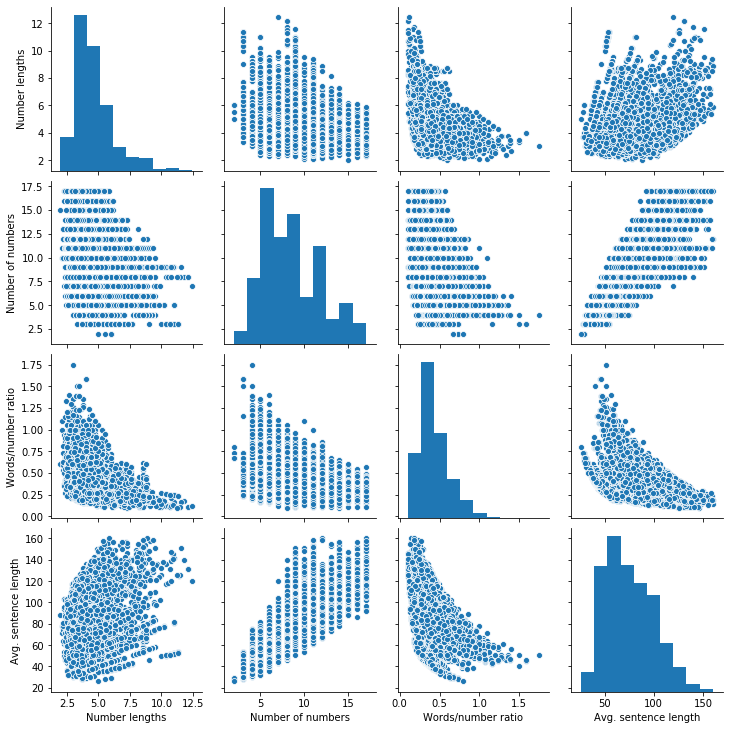

<function count_numbers_length at 0x12a74b840>


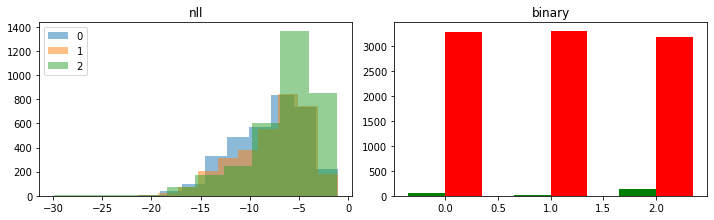

<function count_number_of_numbers at 0x127193ae8>


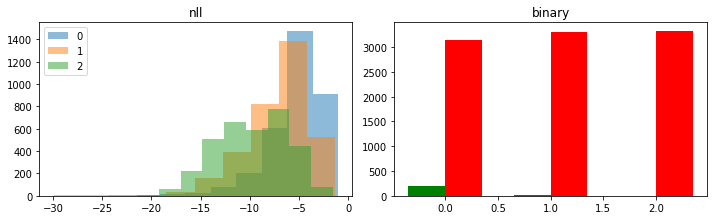

<function ratio_words_numbers at 0x127193ea0>


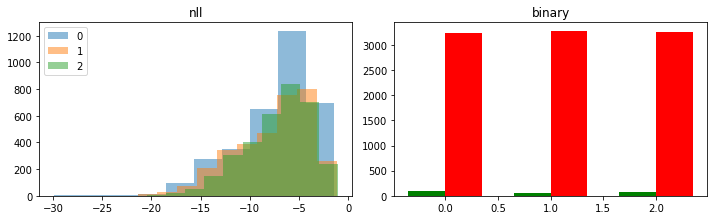

<function len_sentences at 0x127193268>


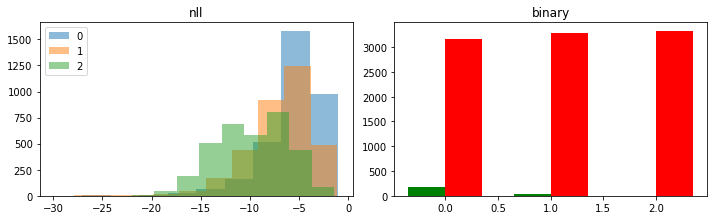

-----------------------------------------------
-----------------------------------------------
arithmetic__add_or_sub_big_src_test.txt
Number lengths:  9.96035
Number of numbers:  2.0
Words/number ratio:  0.5572799690856511
Avg. sentence length:  34.8163


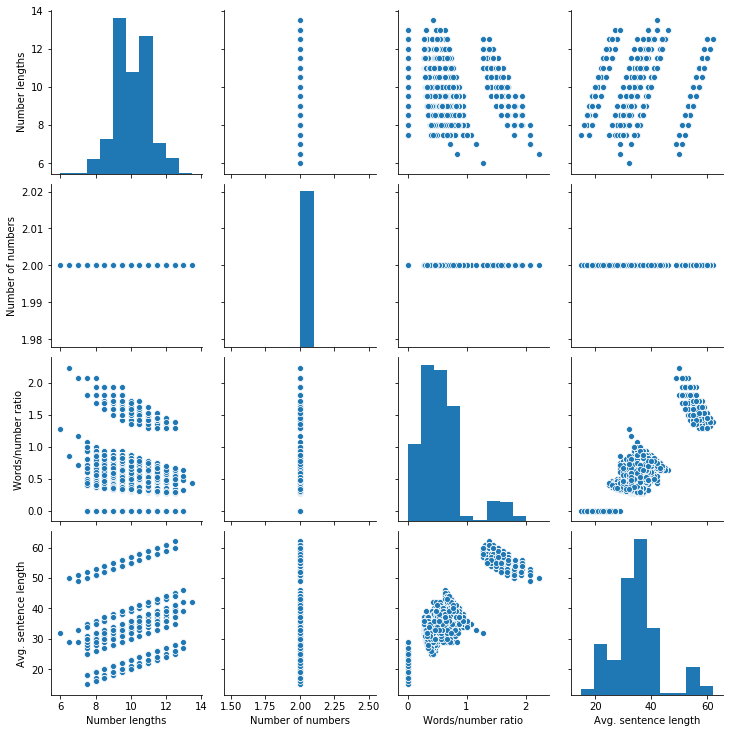

<function count_numbers_length at 0x12a74b840>


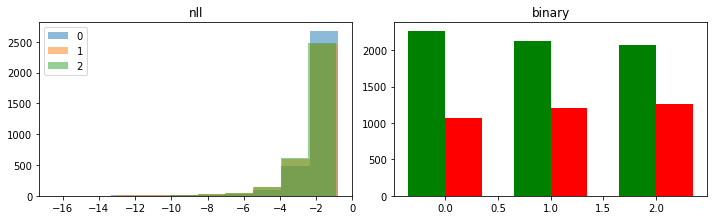

<function count_number_of_numbers at 0x127193ae8>


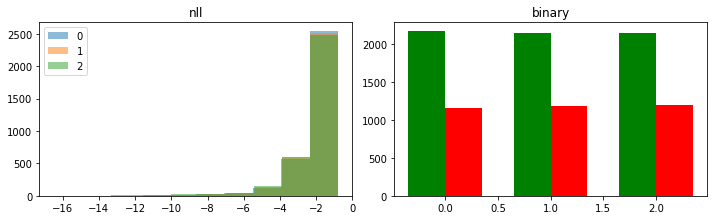

<function ratio_words_numbers at 0x127193ea0>


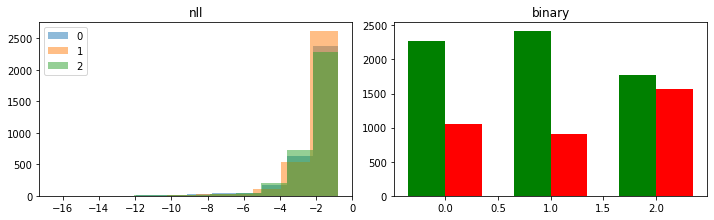

<function len_sentences at 0x127193268>


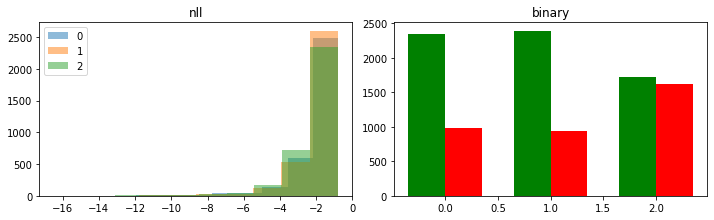

-----------------------------------------------
-----------------------------------------------
arithmetic__add_sub_multiple_longer_src_test.txt
Number lengths:  1.9683419696969697
Number of numbers:  11.0053
Words/number ratio:  0.4789896409931509
Avg. sentence length:  71.0387


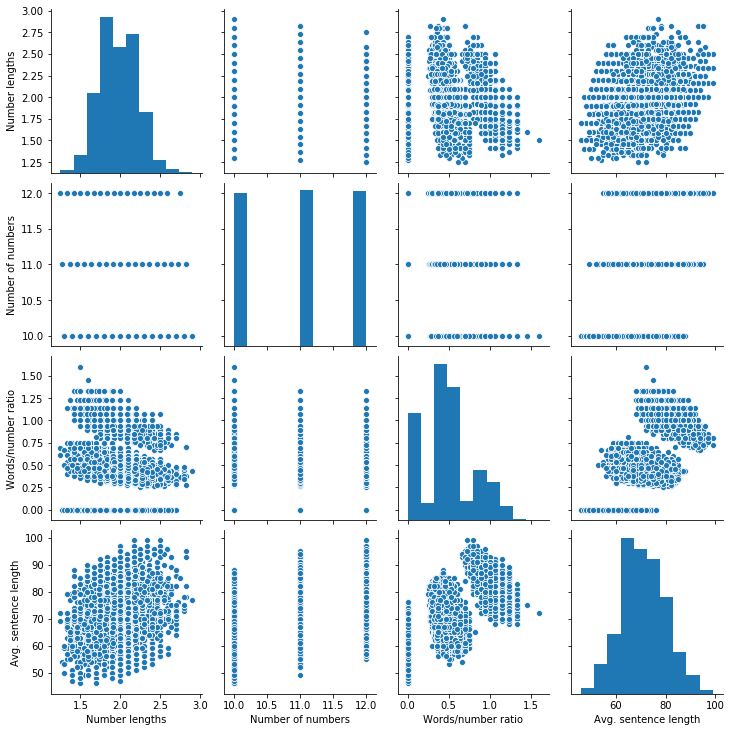

<function count_numbers_length at 0x12a74b840>


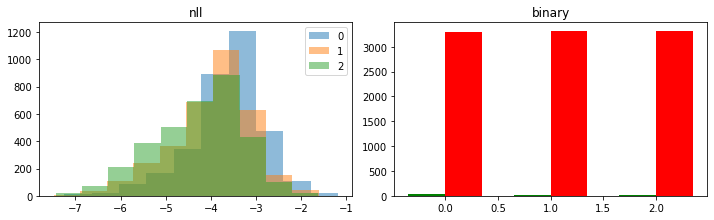

<function count_number_of_numbers at 0x127193ae8>


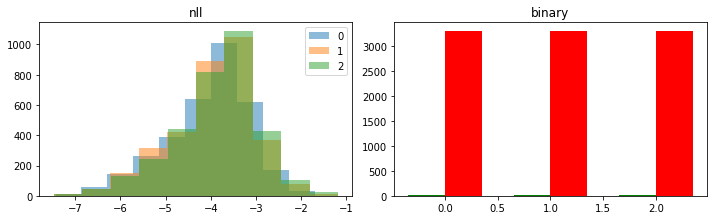

<function ratio_words_numbers at 0x127193ea0>


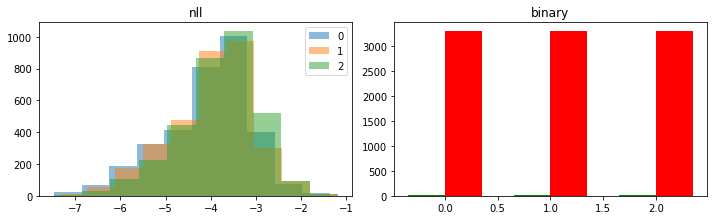

<function len_sentences at 0x127193268>


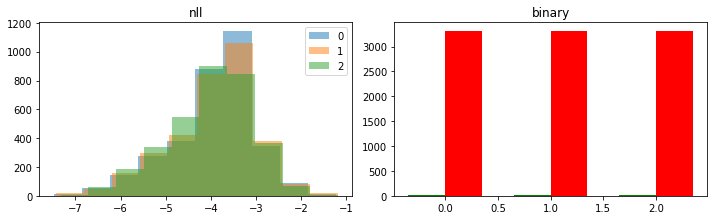

-----------------------------------------------
-----------------------------------------------
arithmetic__div_big_src_test.txt
Number lengths:  7.00295
Number of numbers:  2.0
Words/number ratio:  1.0184090240962205
Avg. sentence length:  31.0249


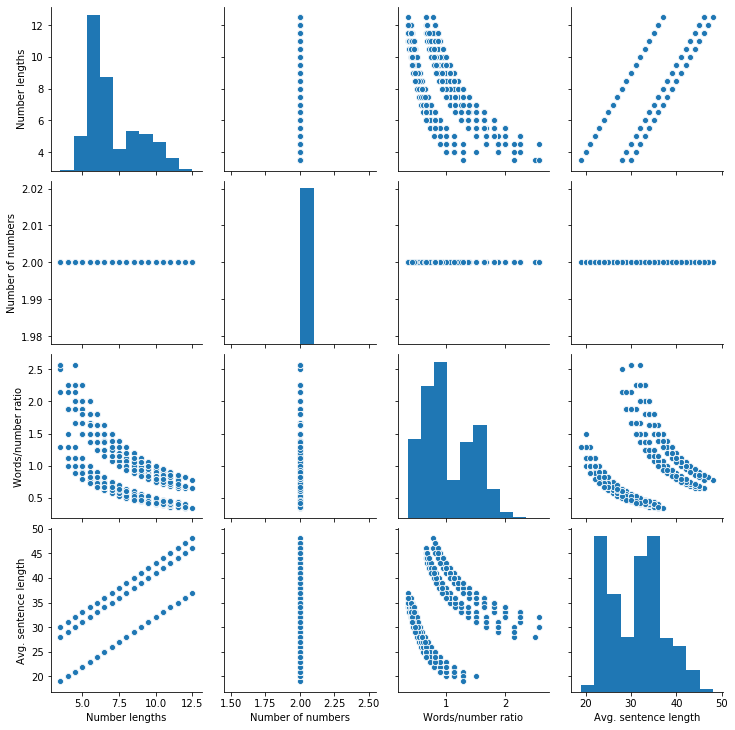

<function count_numbers_length at 0x12a74b840>


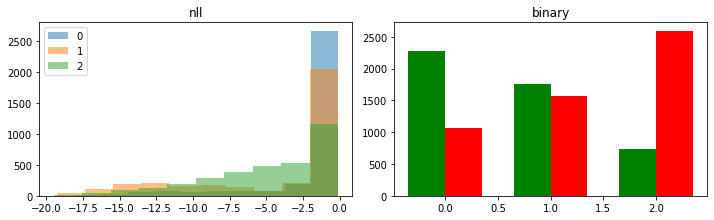

<function count_number_of_numbers at 0x127193ae8>


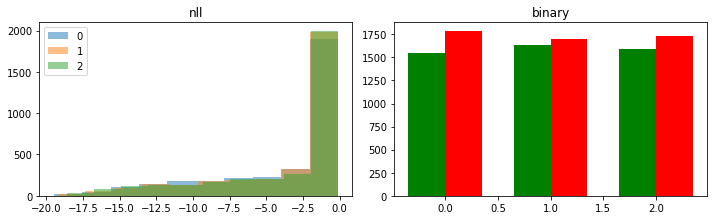

<function ratio_words_numbers at 0x127193ea0>


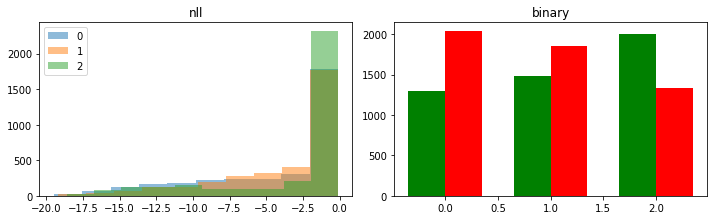

<function len_sentences at 0x127193268>


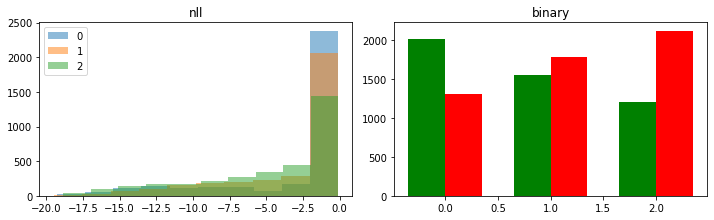

-----------------------------------------------
-----------------------------------------------
arithmetic__mixed_longer_src_test.txt
Number lengths:  2.5201018181818187
Number of numbers:  10.9889
Words/number ratio:  0.3577696178567263
Avg. sentence length:  70.2508


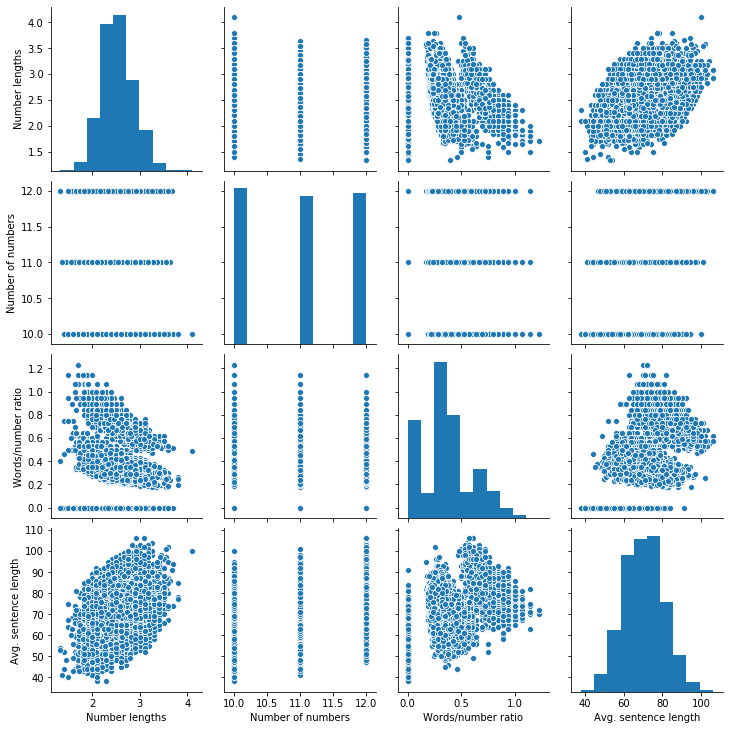

<function count_numbers_length at 0x12a74b840>


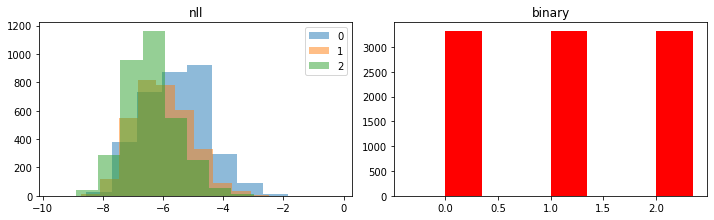

<function count_number_of_numbers at 0x127193ae8>


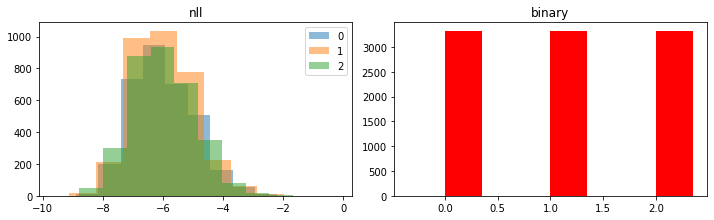

<function ratio_words_numbers at 0x127193ea0>


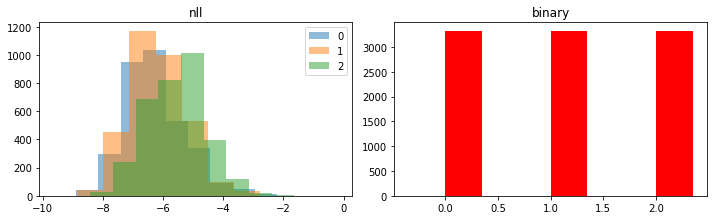

<function len_sentences at 0x127193268>


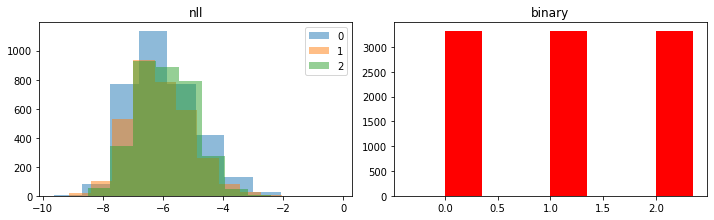

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_big_src_test.txt
Number lengths:  6.56625
Number of numbers:  2.0
Words/number ratio:  0.7593945332445333
Avg. sentence length:  25.6066


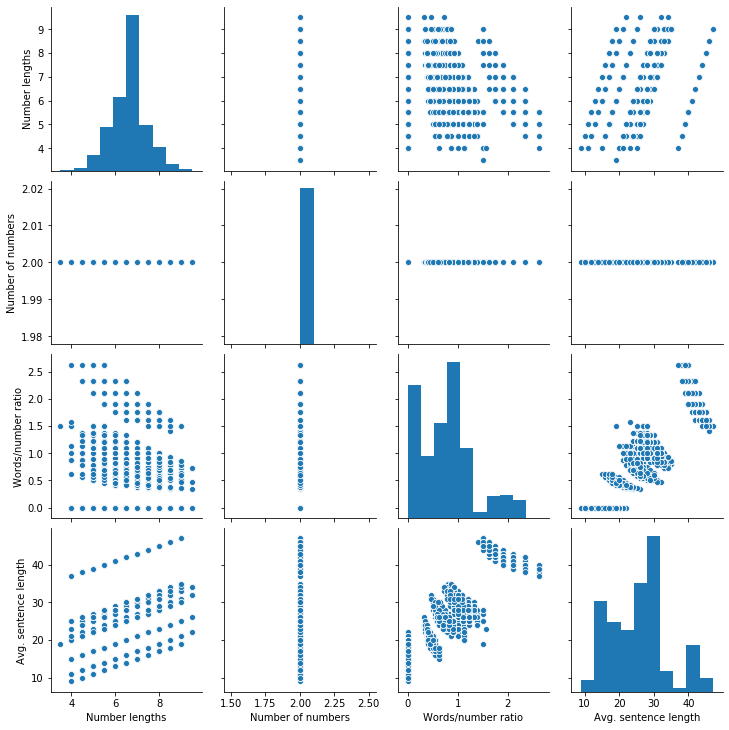

<function count_numbers_length at 0x12a74b840>


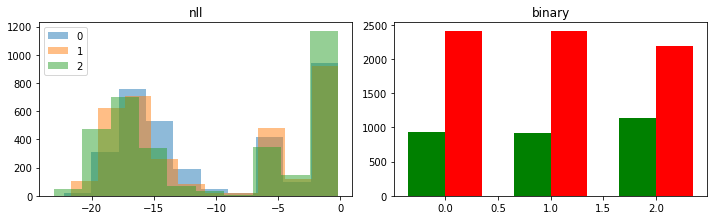

<function count_number_of_numbers at 0x127193ae8>


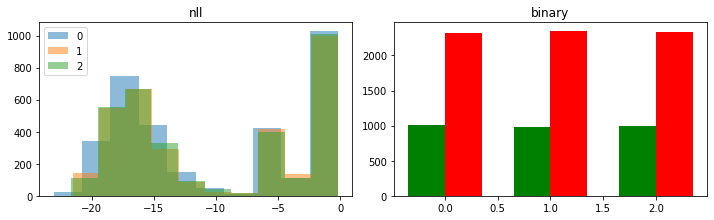

<function ratio_words_numbers at 0x127193ea0>


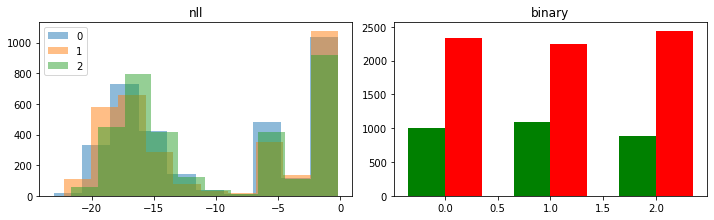

<function len_sentences at 0x127193268>


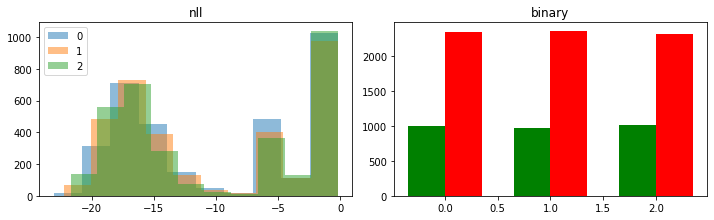

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_div_multiple_longer_src_test.txt
Number lengths:  2.434530303030303
Number of numbers:  11.0183
Words/number ratio:  0.36959042661721403
Avg. sentence length:  66.0063


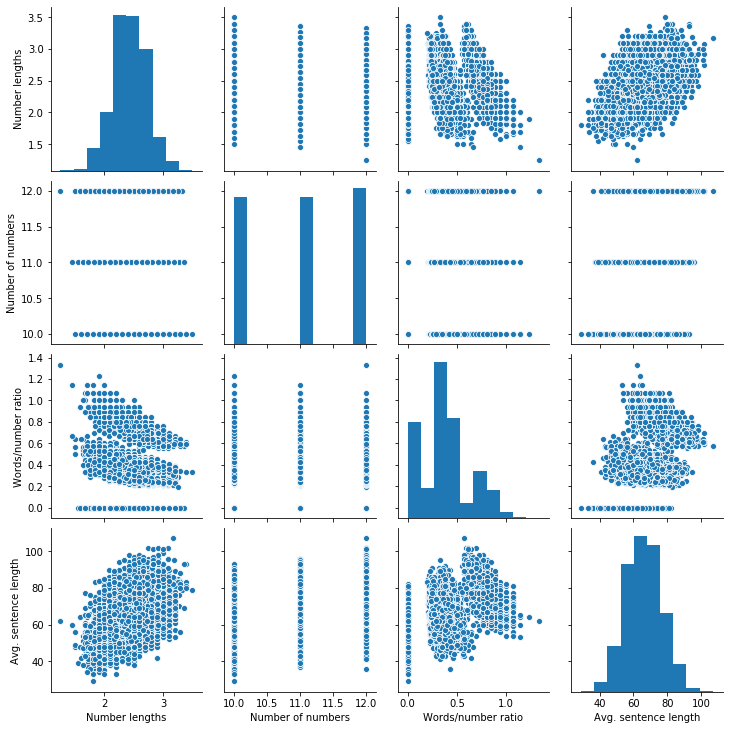

<function count_numbers_length at 0x12a74b840>


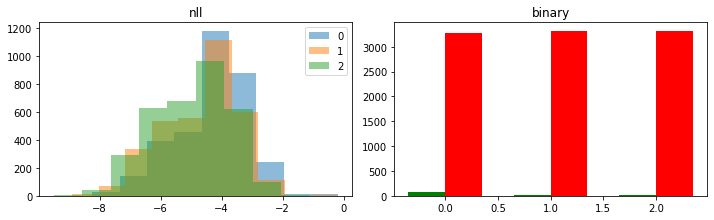

<function count_number_of_numbers at 0x127193ae8>


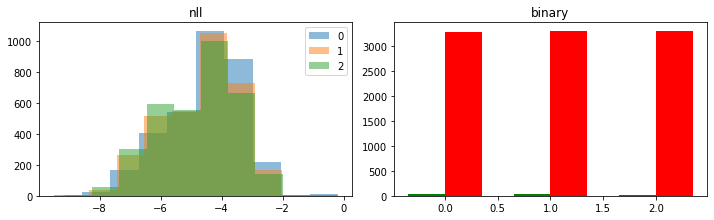

<function ratio_words_numbers at 0x127193ea0>


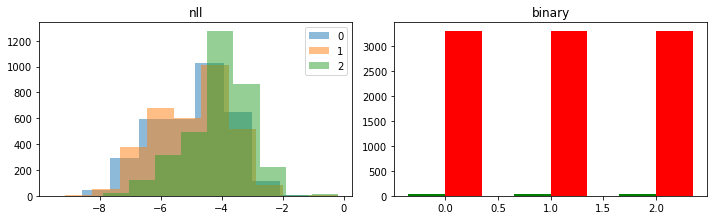

<function len_sentences at 0x127193268>


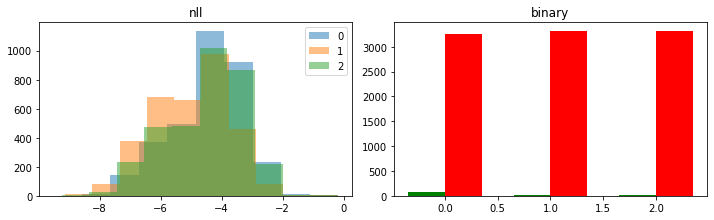

-----------------------------------------------
-----------------------------------------------
comparison__closest_more_src_test.txt
Number lengths:  2.2819910482572983
Number of numbers:  10.727
Words/number ratio:  1.3217867366968532
Avg. sentence length:  82.0469


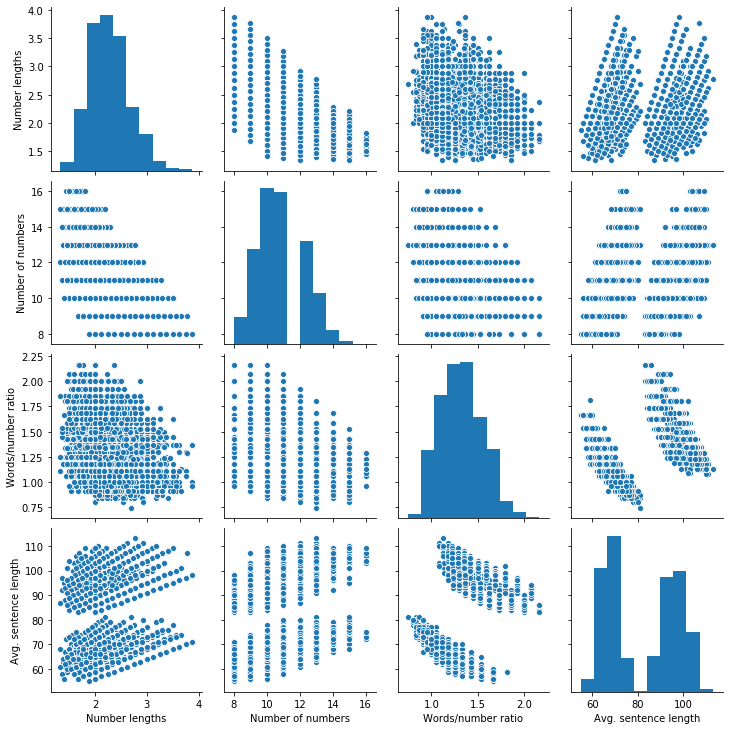

<function count_numbers_length at 0x12a74b840>


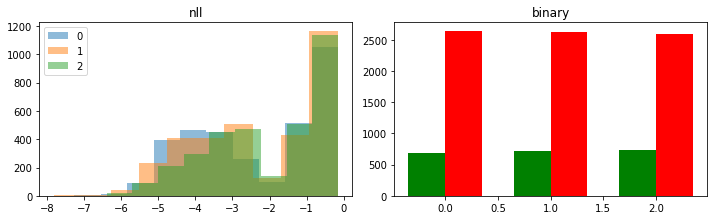

<function count_number_of_numbers at 0x127193ae8>


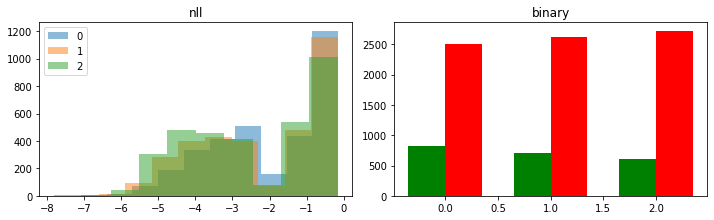

<function ratio_words_numbers at 0x127193ea0>


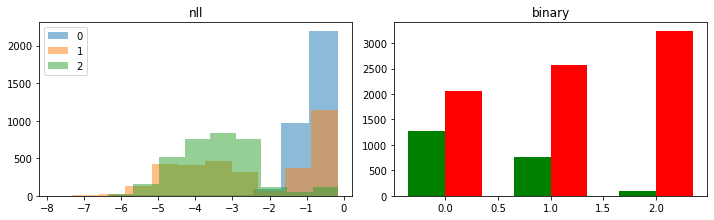

<function len_sentences at 0x127193268>


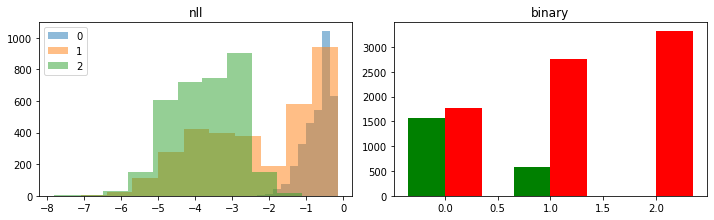

-----------------------------------------------
-----------------------------------------------
comparison__kth_biggest_more_src_test.txt
Number lengths:  2.1956069331893597
Number of numbers:  12.0432
Words/number ratio:  1.7338295127341015
Avg. sentence length:  100.502


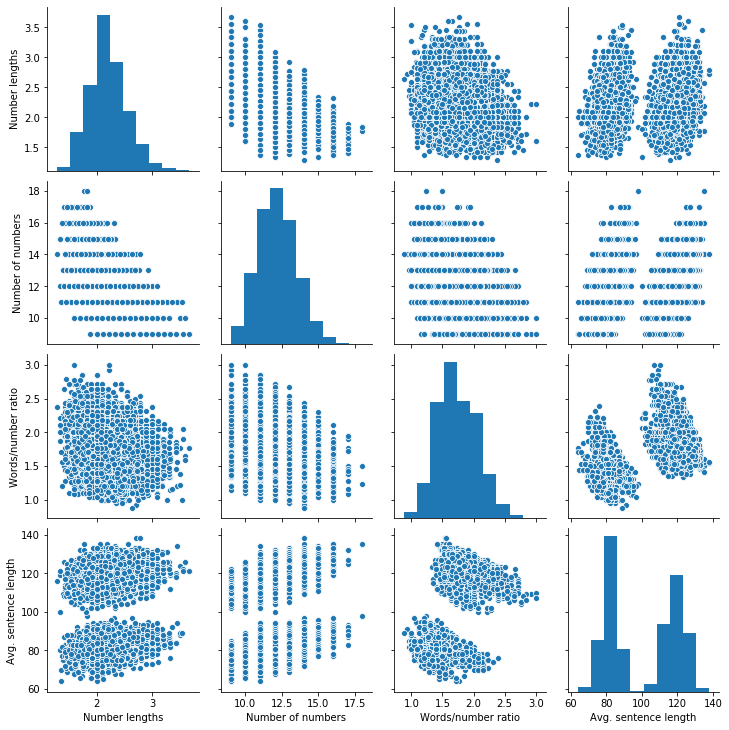

<function count_numbers_length at 0x12a74b840>


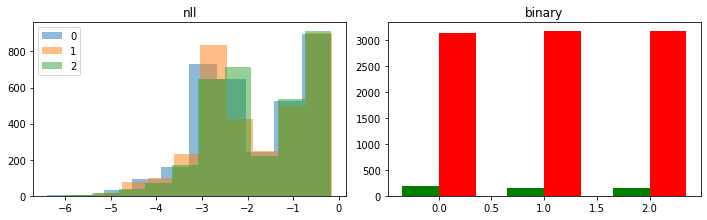

<function count_number_of_numbers at 0x127193ae8>


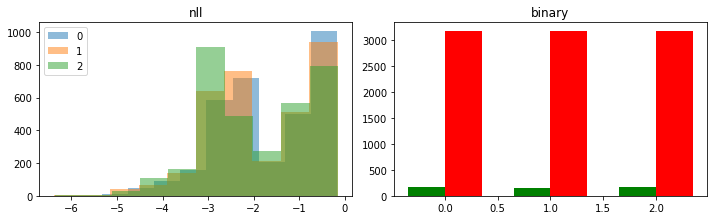

<function ratio_words_numbers at 0x127193ea0>


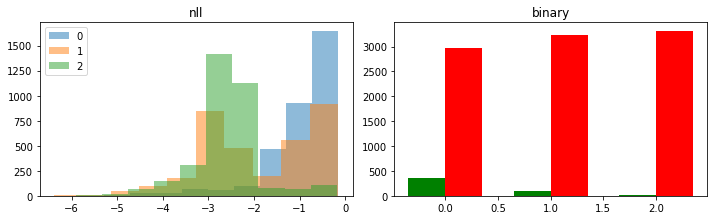

<function len_sentences at 0x127193268>


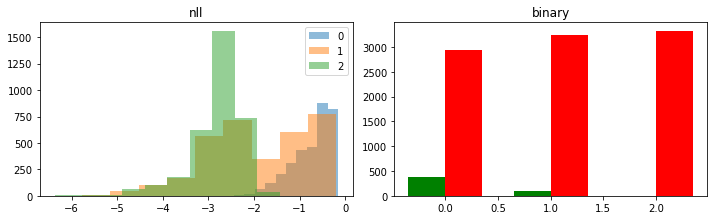

-----------------------------------------------
-----------------------------------------------
comparison__sort_more_src_test.txt
Number lengths:  1.5303688888888891
Number of numbers:  9.0009
Words/number ratio:  1.5180260256410256
Avg. sentence length:  51.9703


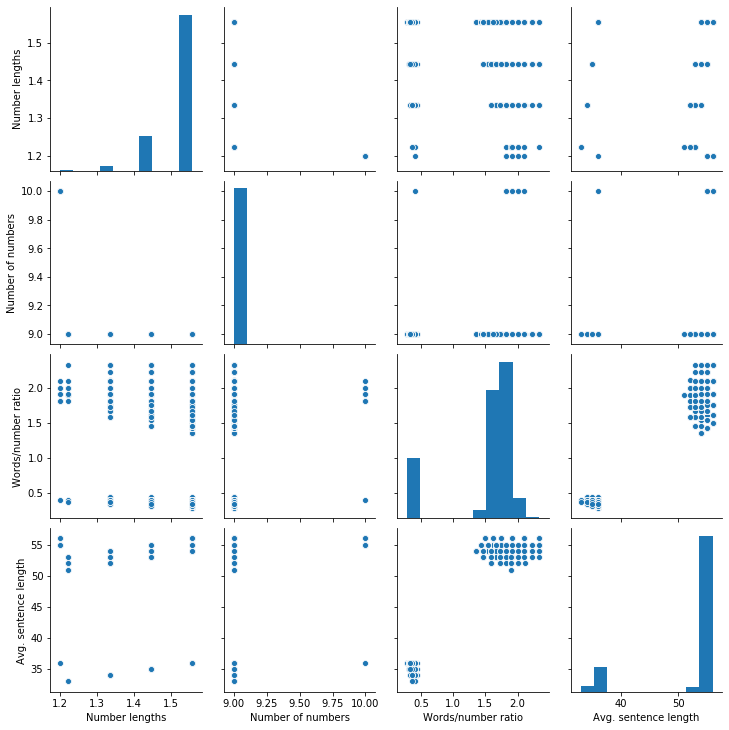

<function count_numbers_length at 0x12a74b840>


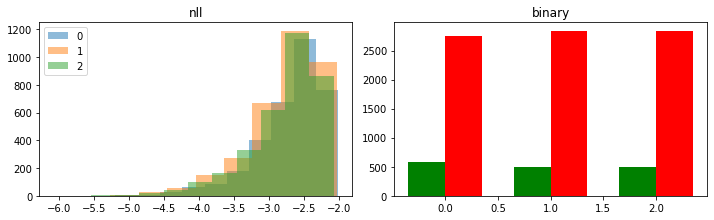

<function count_number_of_numbers at 0x127193ae8>


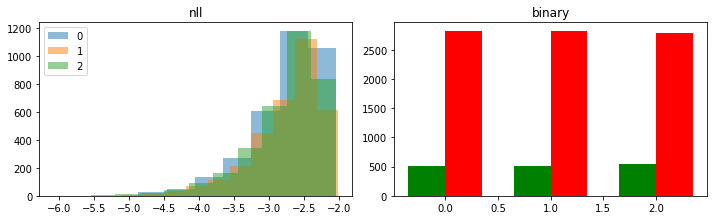

<function ratio_words_numbers at 0x127193ea0>


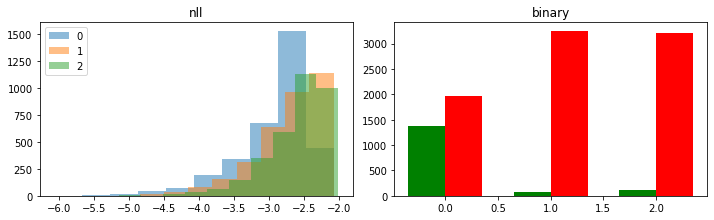

<function len_sentences at 0x127193268>


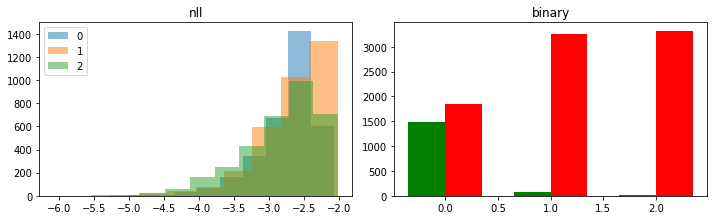

-----------------------------------------------
-----------------------------------------------
measurement__conversion_src_test.txt
Number lengths:  10.0397
Number of numbers:  1.0
Words/number ratio:  2.8335952200577204
Avg. sentence length:  41.4646


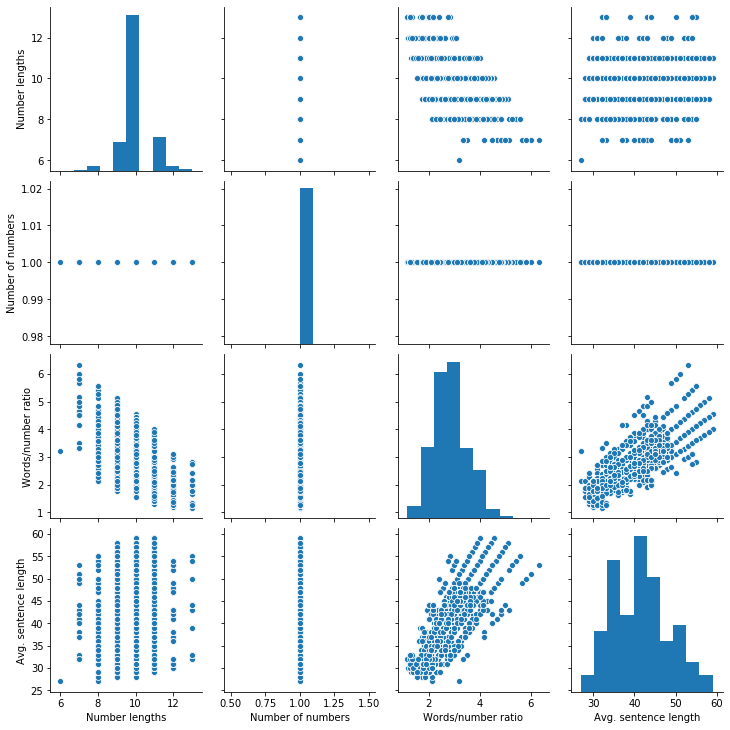

<function count_numbers_length at 0x12a74b840>


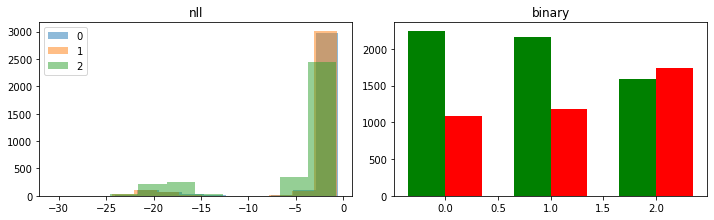

<function count_number_of_numbers at 0x127193ae8>


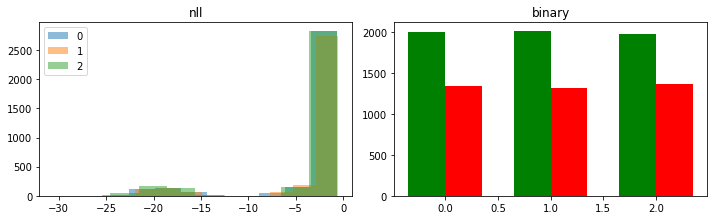

<function ratio_words_numbers at 0x127193ea0>


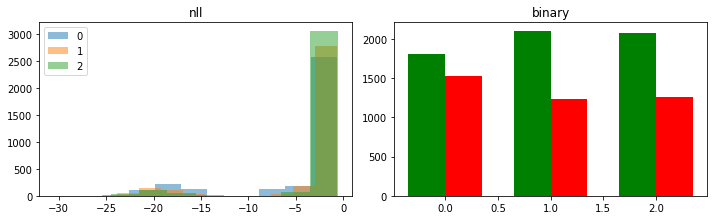

<function len_sentences at 0x127193268>


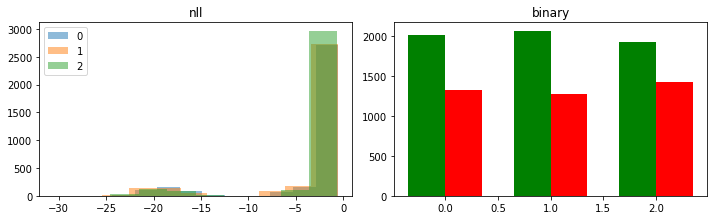

-----------------------------------------------
-----------------------------------------------
numbers__place_value_big_src_test.txt
Number lengths:  11.8893
Number of numbers:  1.0
Words/number ratio:  2.1963368434343438
Avg. sentence length:  45.4757


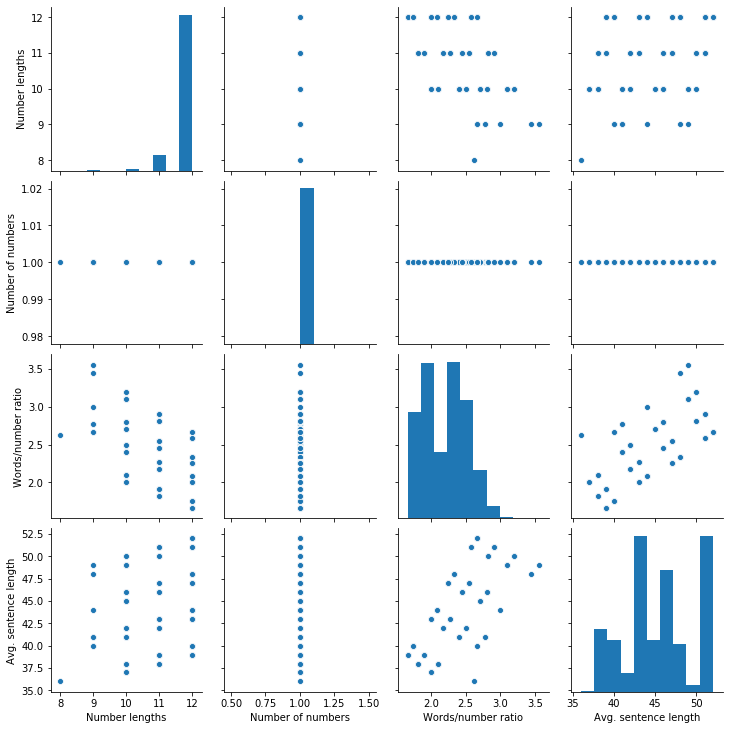

<function count_numbers_length at 0x12a74b840>


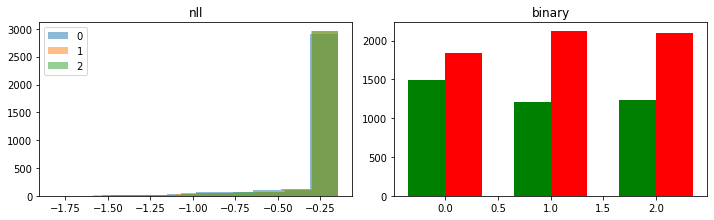

<function count_number_of_numbers at 0x127193ae8>


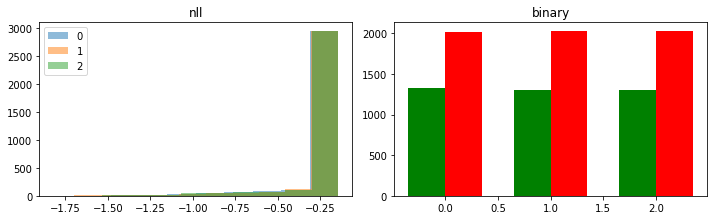

<function ratio_words_numbers at 0x127193ea0>


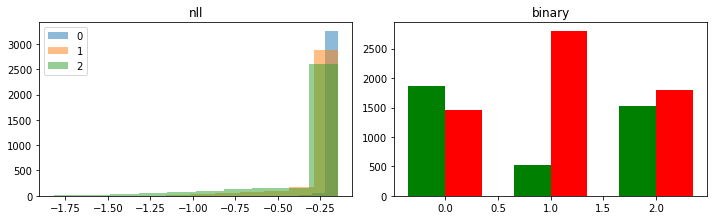

<function len_sentences at 0x127193268>


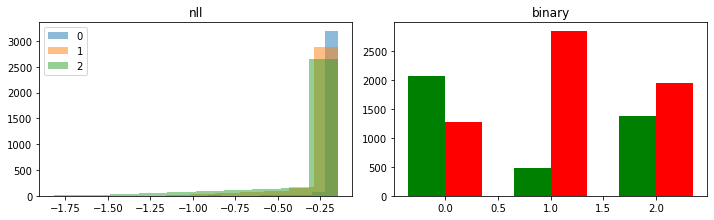

-----------------------------------------------
-----------------------------------------------
numbers__round_number_big_src_test.txt
Number lengths:  11.644
Number of numbers:  1.4839
Words/number ratio:  1.6993409223443396
Avg. sentence length:  46.0797


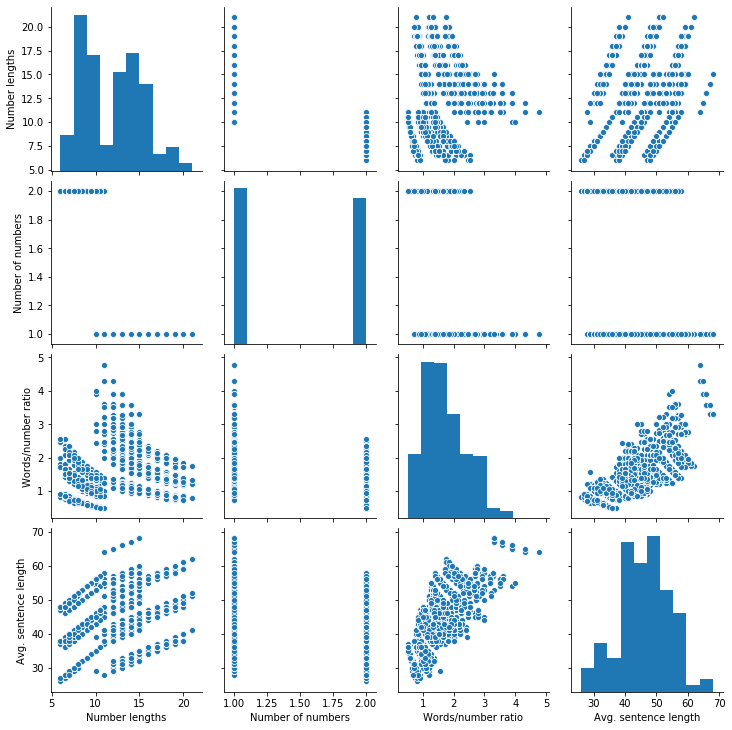

<function count_numbers_length at 0x12a74b840>


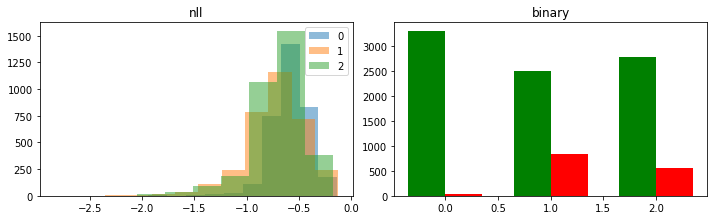

<function count_number_of_numbers at 0x127193ae8>


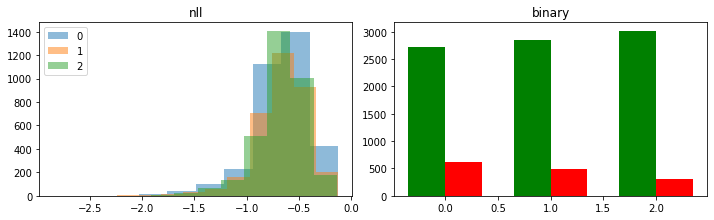

<function ratio_words_numbers at 0x127193ea0>


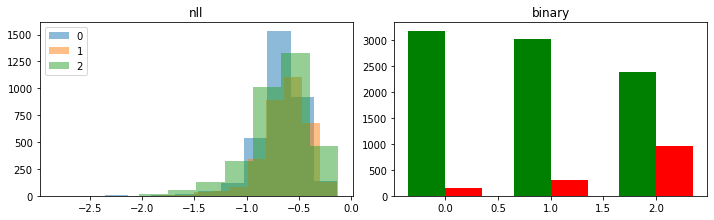

<function len_sentences at 0x127193268>


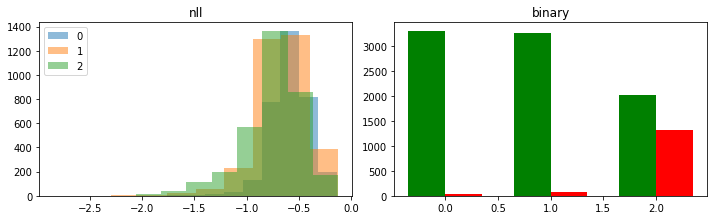

-----------------------------------------------
-----------------------------------------------
probability__swr_p_level_set_more_samples_src_test.txt
Number lengths:  1.0269748448773448
Number of numbers:  4.2769
Words/number ratio:  25.070210295815293
Avg. sentence length:  105.2311


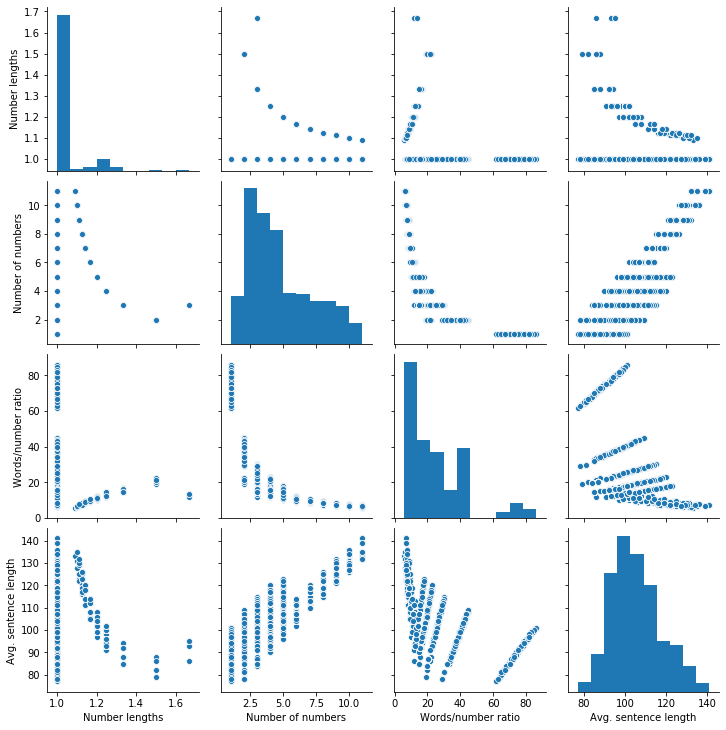

<function count_numbers_length at 0x12a74b840>


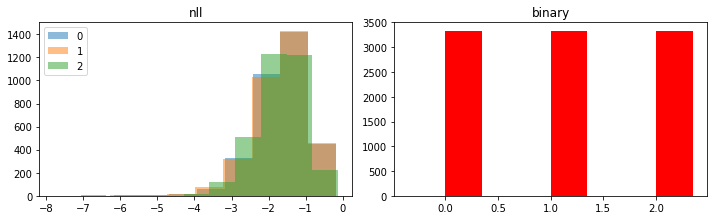

<function count_number_of_numbers at 0x127193ae8>


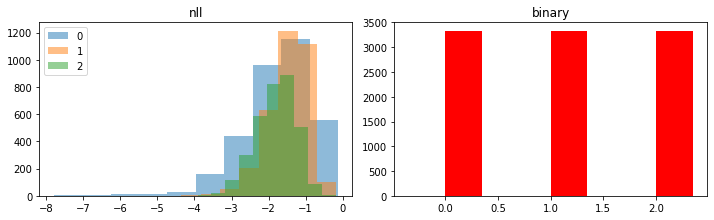

<function ratio_words_numbers at 0x127193ea0>


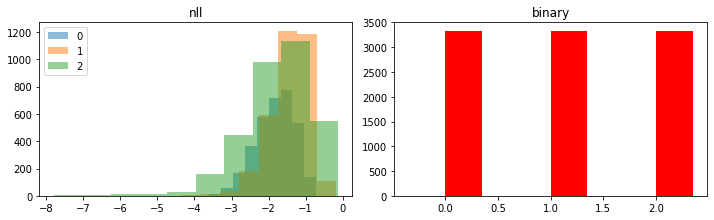

<function len_sentences at 0x127193268>


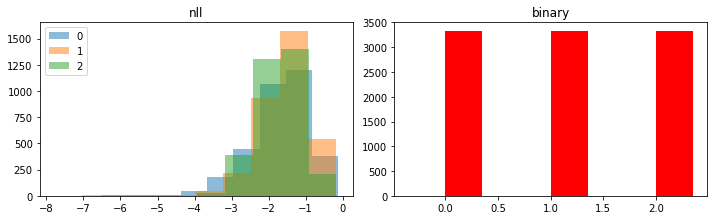

-----------------------------------------------
-----------------------------------------------
probability__swr_p_sequence_more_samples_src_test.txt
Number lengths:  0.5380999999999999
Number of numbers:  1.8574
Words/number ratio:  10.20174880952381
Avg. sentence length:  97.9472


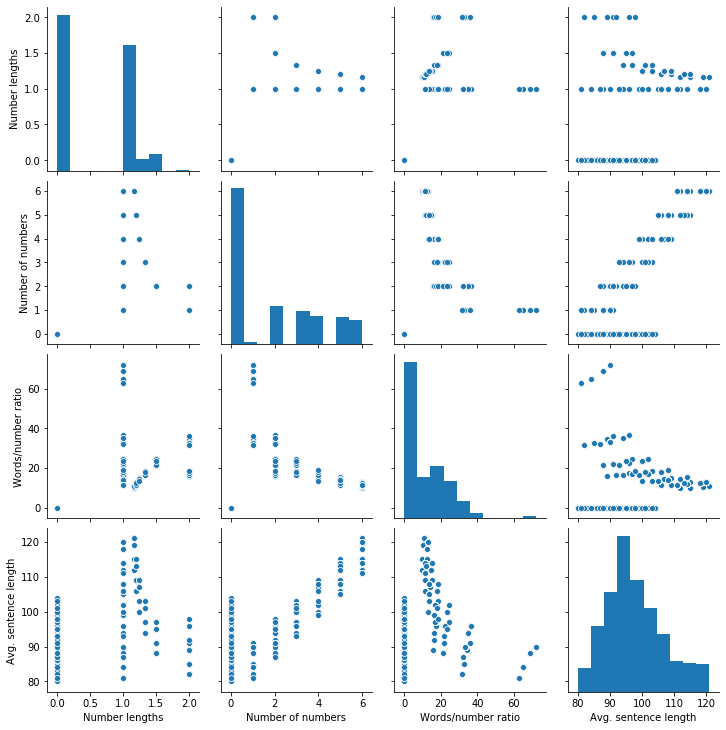

<function count_numbers_length at 0x12a74b840>


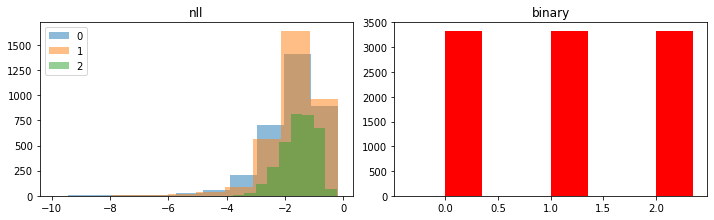

<function count_number_of_numbers at 0x127193ae8>


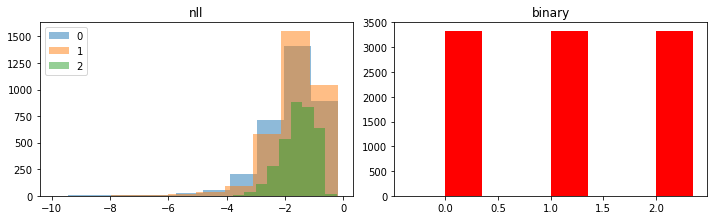

<function ratio_words_numbers at 0x127193ea0>


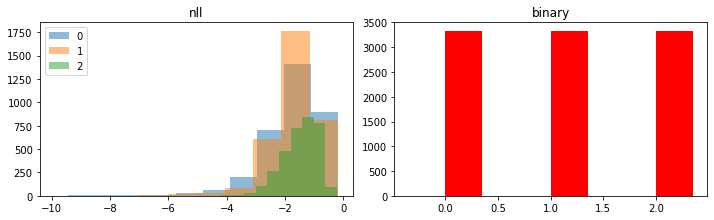

<function len_sentences at 0x127193268>


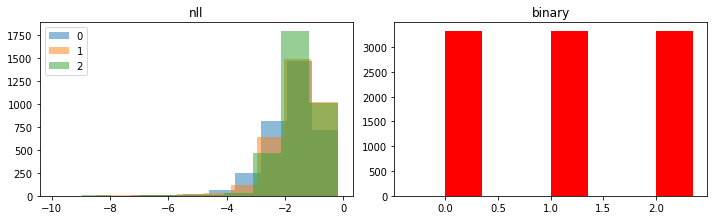

-----------------------------------------------

***********************
interpolate
***********************

-----------------------------------------------
algebra__polynomial_roots_src_test.txt
Number lengths:  3.1163365279328517
Number of numbers:  8.1196
Words/number ratio:  0.6283470803728768
Avg. sentence length:  61.6788


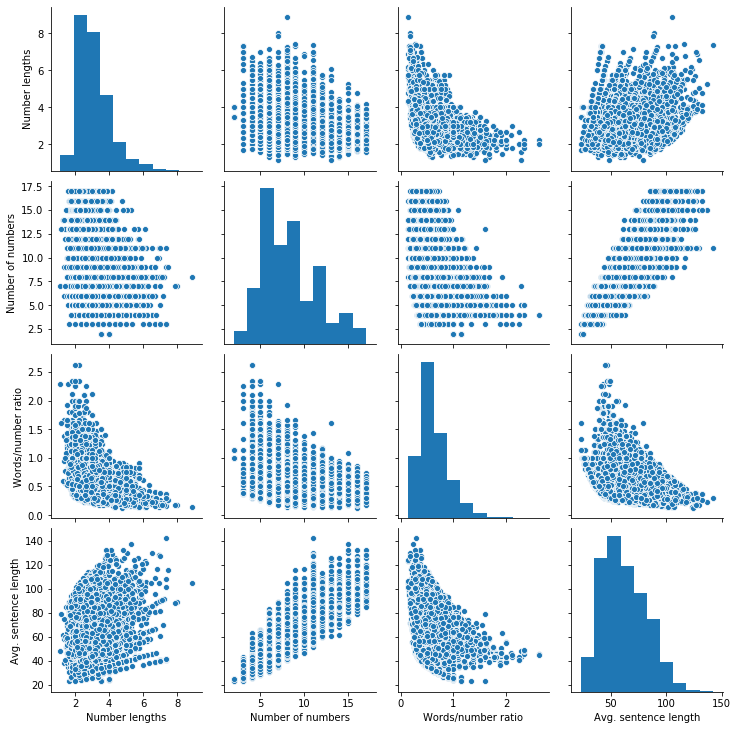

<function count_numbers_length at 0x12a74b840>


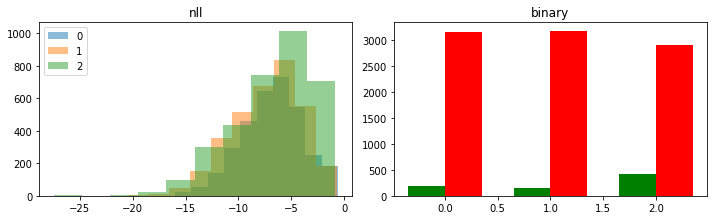

<function count_number_of_numbers at 0x127193ae8>


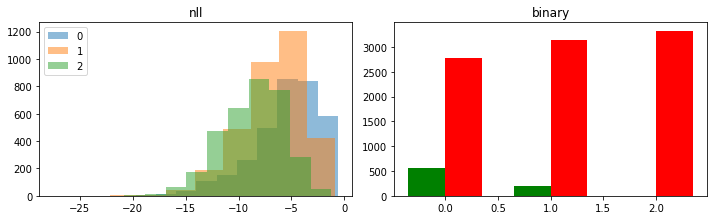

<function ratio_words_numbers at 0x127193ea0>


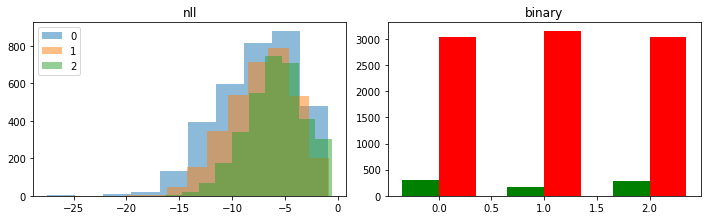

<function len_sentences at 0x127193268>


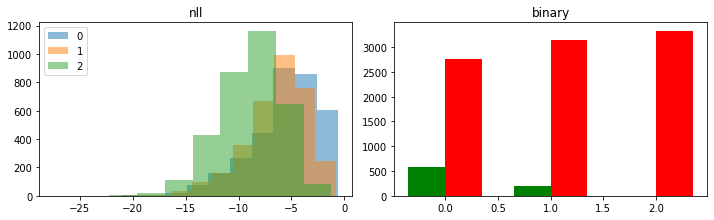

-----------------------------------------------
-----------------------------------------------
arithmetic__add_or_sub_src_test.txt
Number lengths:  7.05825
Number of numbers:  2.0
Words/number ratio:  0.8217965401265401
Avg. sentence length:  29.0014


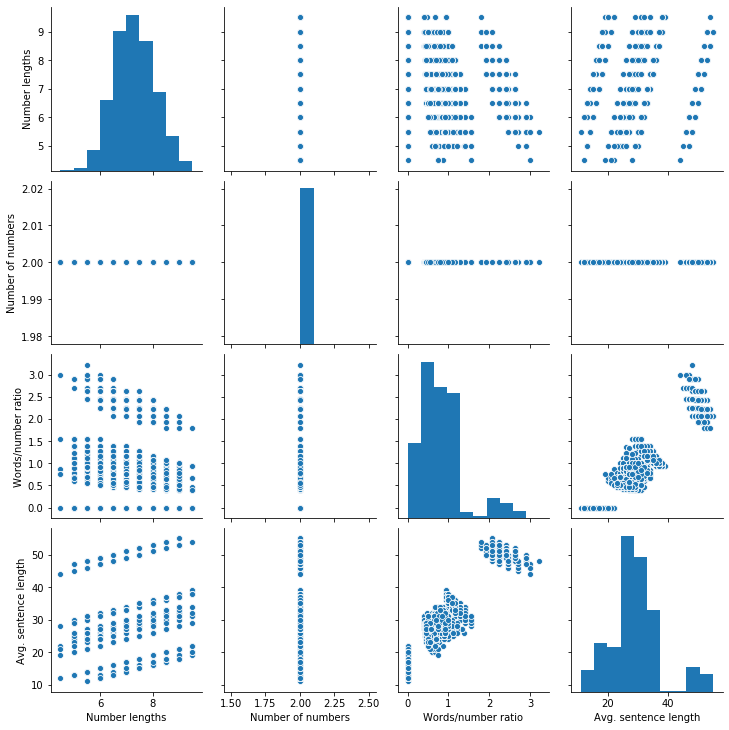

<function count_numbers_length at 0x12a74b840>


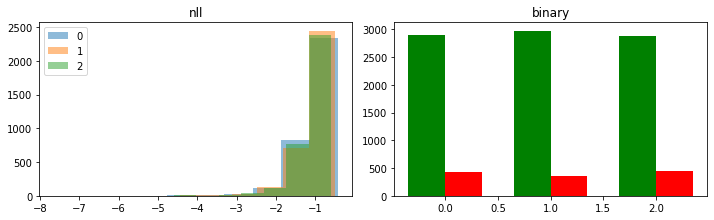

<function count_number_of_numbers at 0x127193ae8>


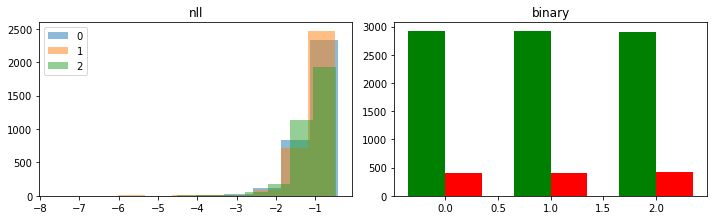

<function ratio_words_numbers at 0x127193ea0>


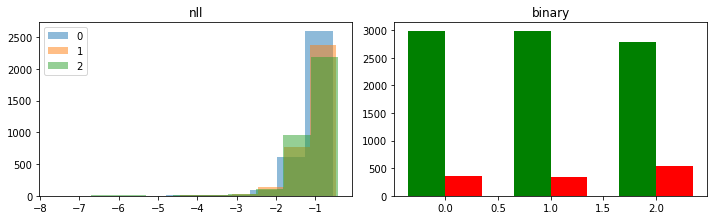

<function len_sentences at 0x127193268>


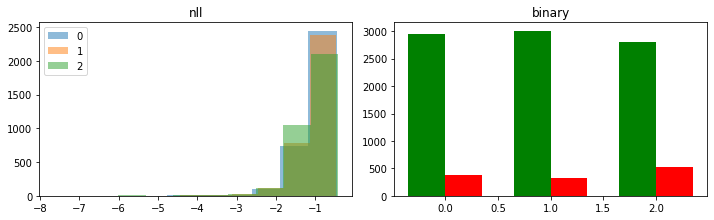

-----------------------------------------------
-----------------------------------------------
arithmetic__add_sub_multiple_src_test.txt
Number lengths:  2.1482759523809523
Number of numbers:  5.5007
Words/number ratio:  0.9152499474136974
Avg. sentence length:  39.1554


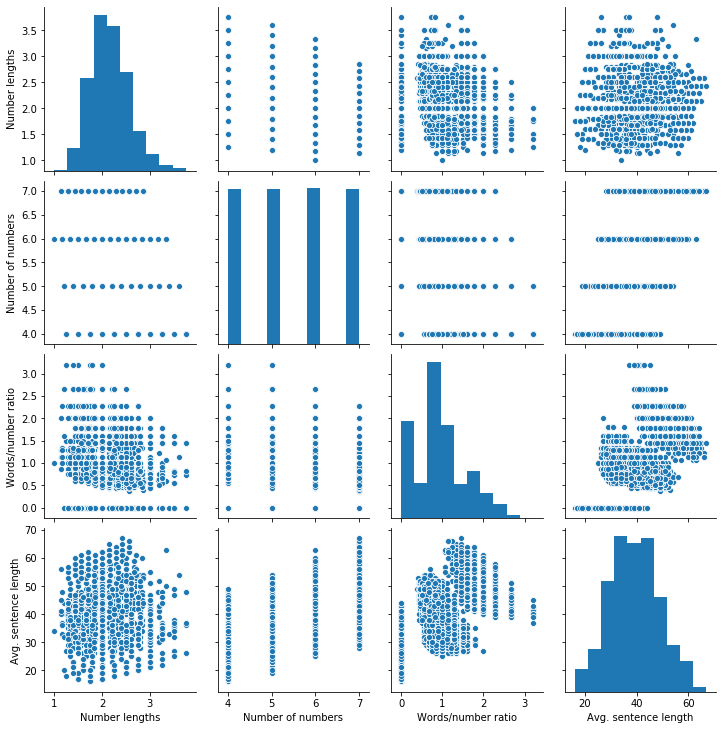

<function count_numbers_length at 0x12a74b840>


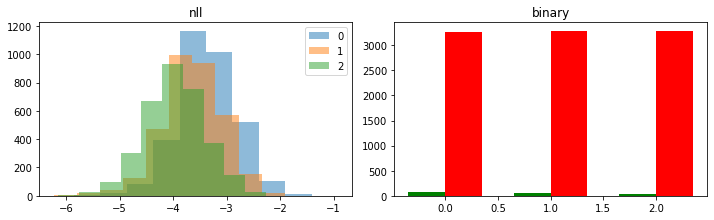

<function count_number_of_numbers at 0x127193ae8>


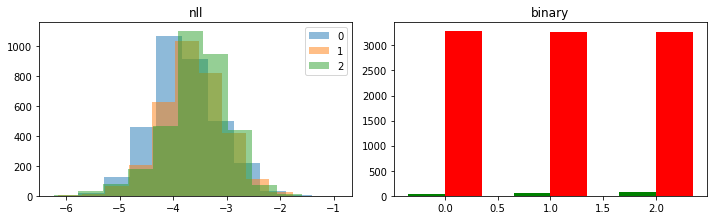

<function ratio_words_numbers at 0x127193ea0>


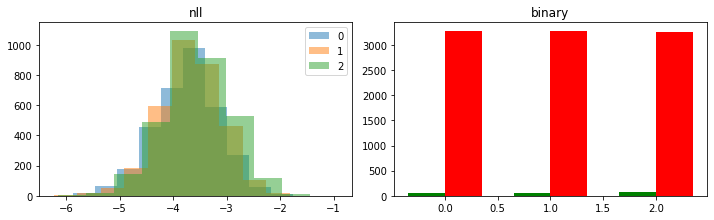

<function len_sentences at 0x127193268>


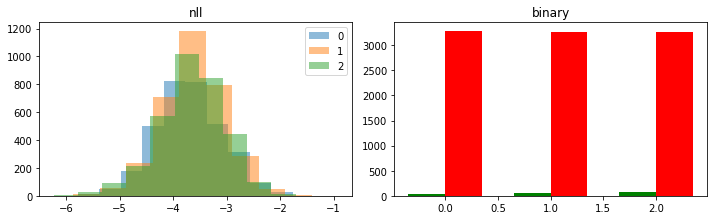

-----------------------------------------------
-----------------------------------------------
arithmetic__div_src_test.txt
Number lengths:  5.12935
Number of numbers:  2.0
Words/number ratio:  1.424125429015429
Avg. sentence length:  27.2866


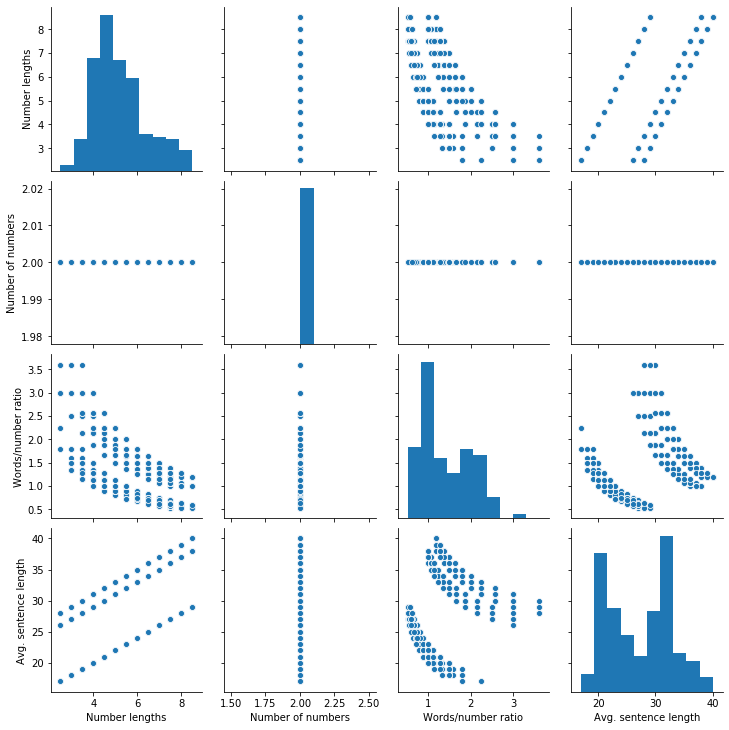

<function count_numbers_length at 0x12a74b840>


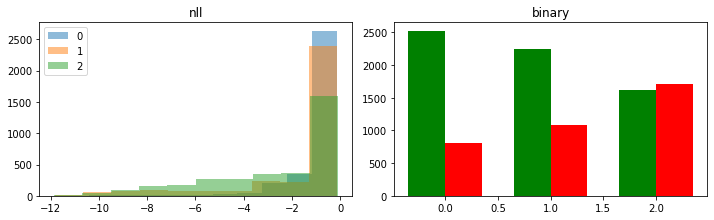

<function count_number_of_numbers at 0x127193ae8>


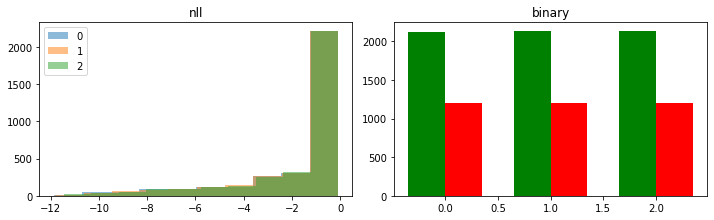

<function ratio_words_numbers at 0x127193ea0>


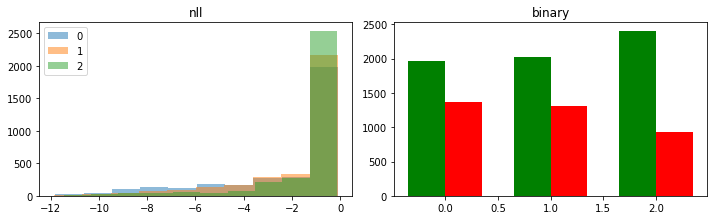

<function len_sentences at 0x127193268>


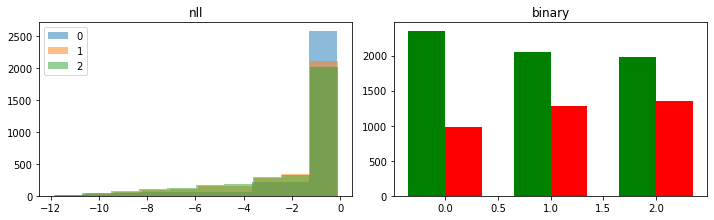

-----------------------------------------------
-----------------------------------------------
arithmetic__mixed_src_test.txt
Number lengths:  2.8096735714285717
Number of numbers:  5.508
Words/number ratio:  0.6552483544615858
Avg. sentence length:  39.6907


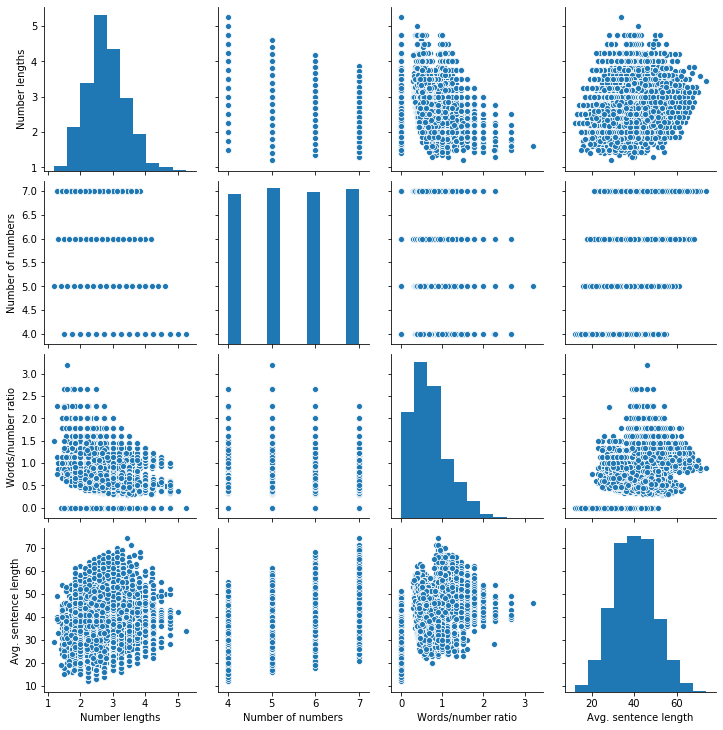

<function count_numbers_length at 0x12a74b840>


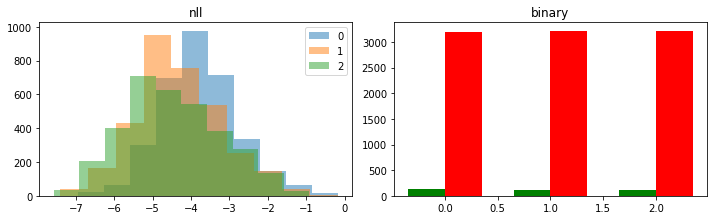

<function count_number_of_numbers at 0x127193ae8>


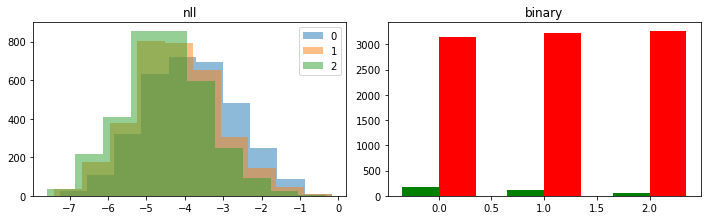

<function ratio_words_numbers at 0x127193ea0>


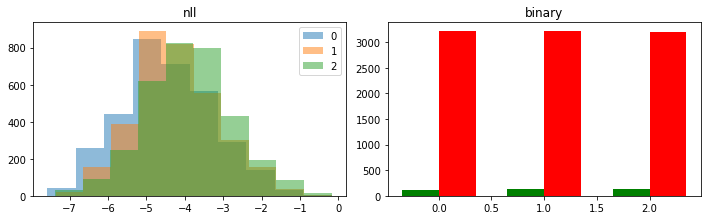

<function len_sentences at 0x127193268>


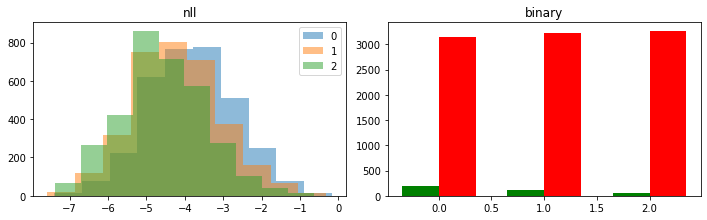

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_div_multiple_src_test.txt
Number lengths:  2.743665
Number of numbers:  5.4925
Words/number ratio:  0.6660072892196383
Avg. sentence length:  38.0891


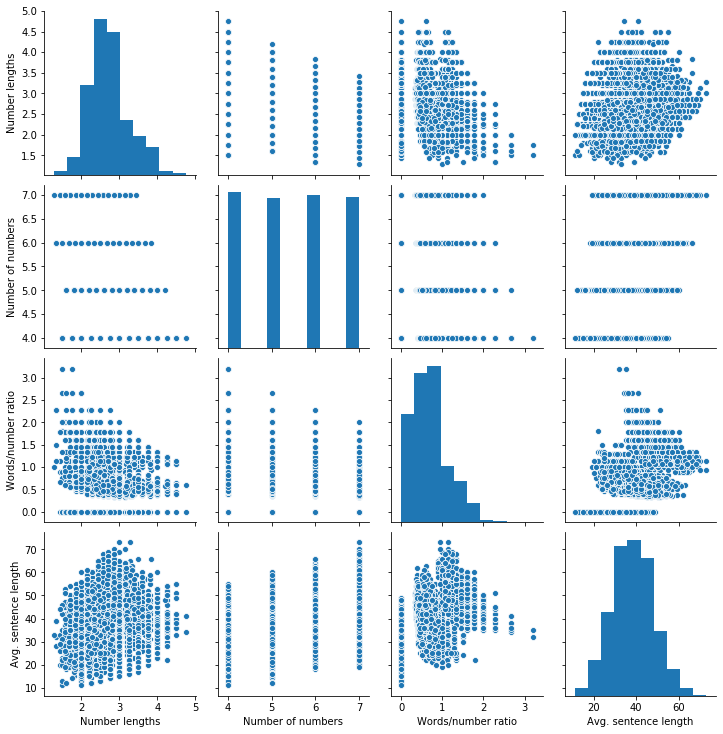

<function count_numbers_length at 0x12a74b840>


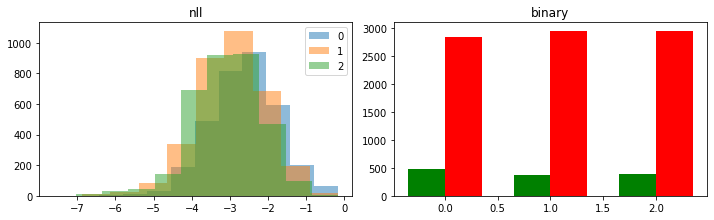

<function count_number_of_numbers at 0x127193ae8>


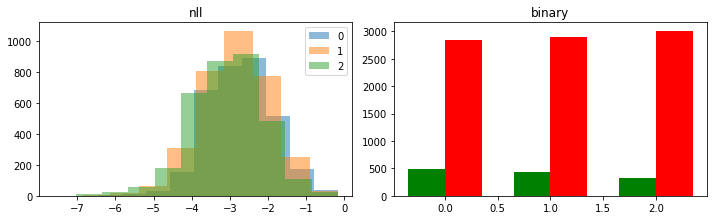

<function ratio_words_numbers at 0x127193ea0>


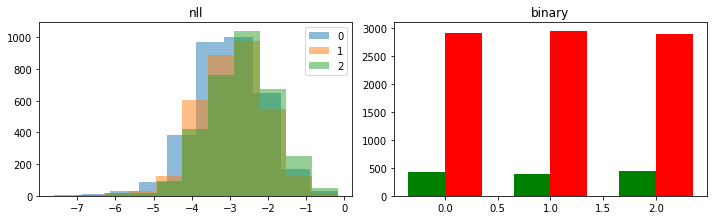

<function len_sentences at 0x127193268>


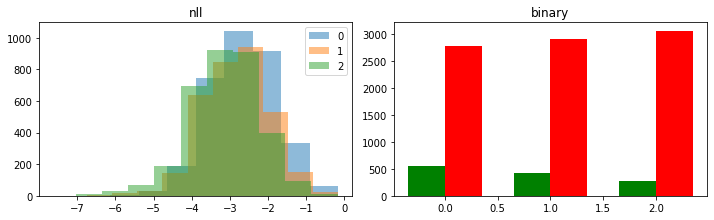

-----------------------------------------------
-----------------------------------------------
arithmetic__mul_src_test.txt
Number lengths:  5.12925
Number of numbers:  2.0
Words/number ratio:  1.0344311255411256
Avg. sentence length:  22.784


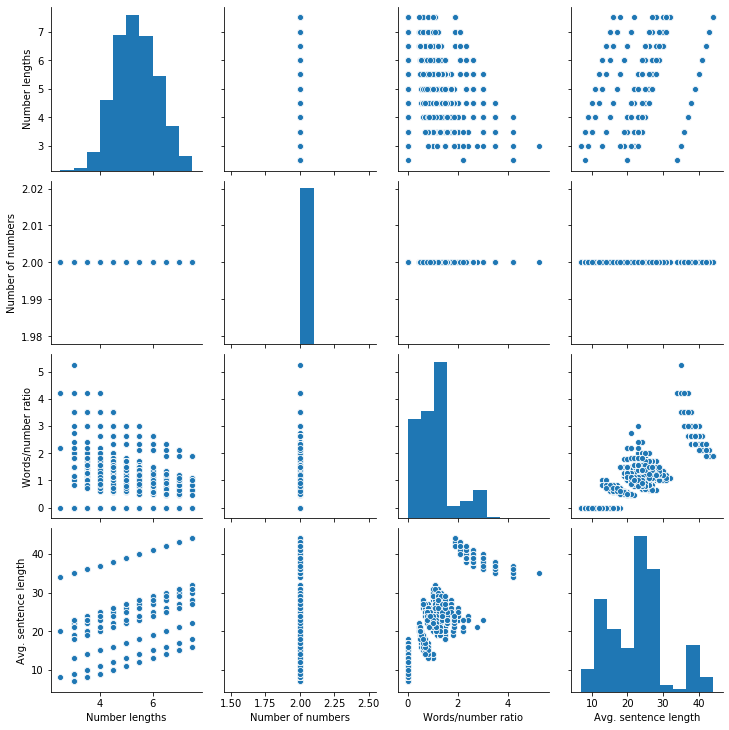

<function count_numbers_length at 0x12a74b840>


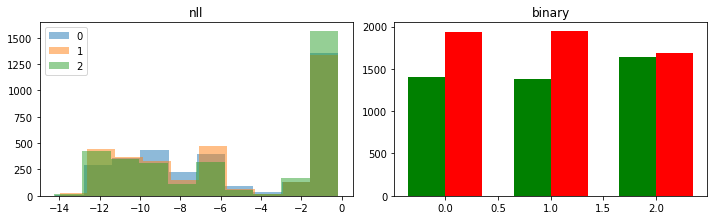

<function count_number_of_numbers at 0x127193ae8>


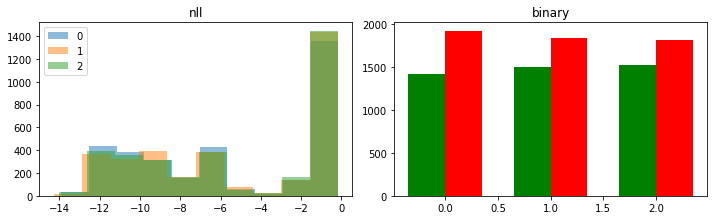

<function ratio_words_numbers at 0x127193ea0>


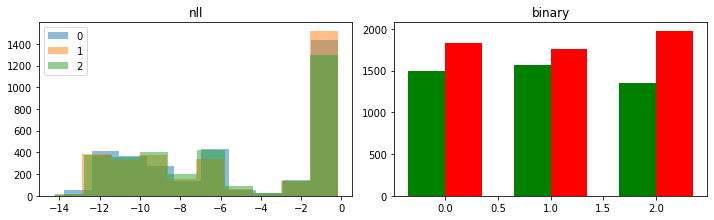

<function len_sentences at 0x127193268>


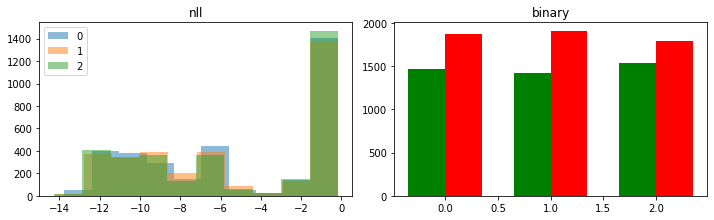

-----------------------------------------------
-----------------------------------------------
comparison__closest_src_test.txt
Number lengths:  2.4166485137085134
Number of numbers:  6.2938
Words/number ratio:  1.9947098396701337
Avg. sentence length:  57.5819


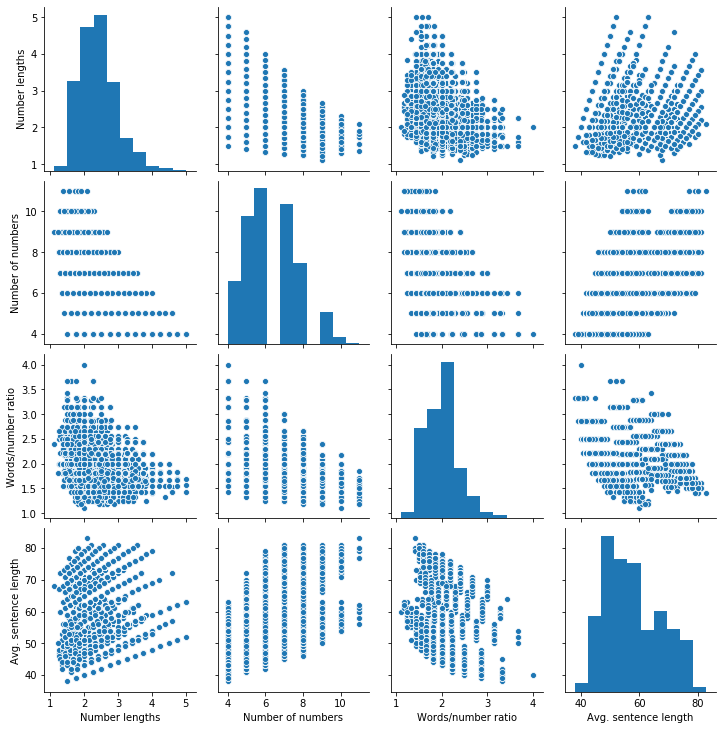

<function count_numbers_length at 0x12a74b840>


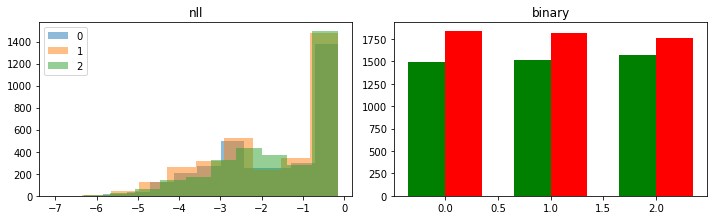

<function count_number_of_numbers at 0x127193ae8>


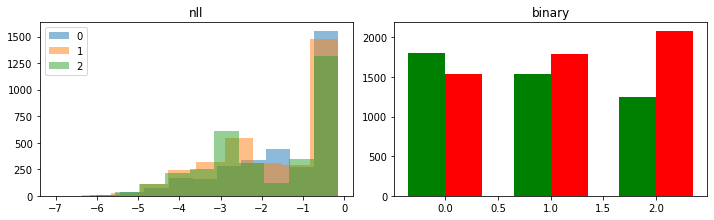

<function ratio_words_numbers at 0x127193ea0>


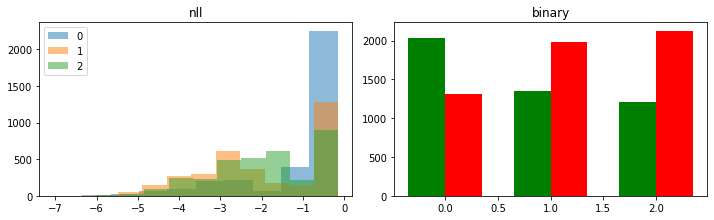

<function len_sentences at 0x127193268>


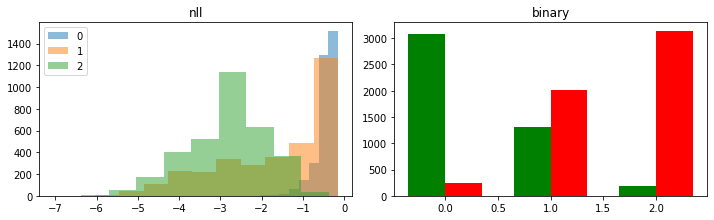

-----------------------------------------------
-----------------------------------------------
comparison__kth_biggest_src_test.txt
Number lengths:  2.510907972860473
Number of numbers:  6.2663
Words/number ratio:  2.778442775131645
Avg. sentence length:  69.1863


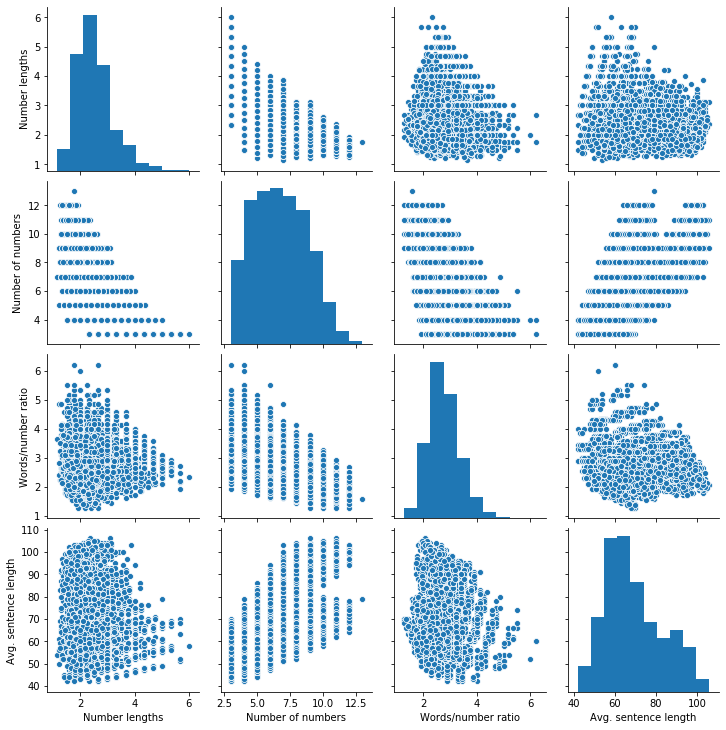

<function count_numbers_length at 0x12a74b840>


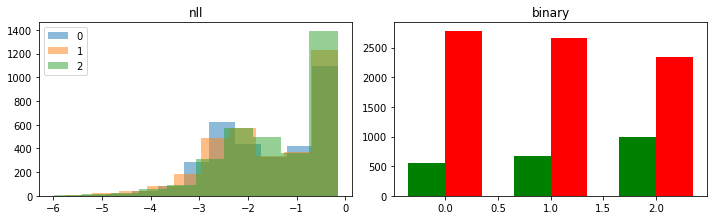

<function count_number_of_numbers at 0x127193ae8>


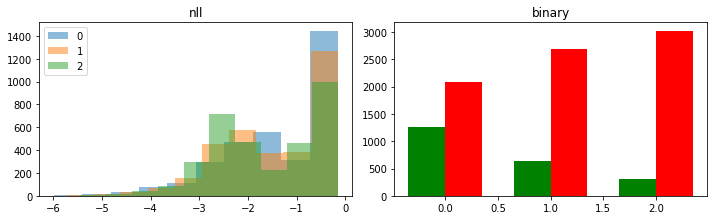

<function ratio_words_numbers at 0x127193ea0>


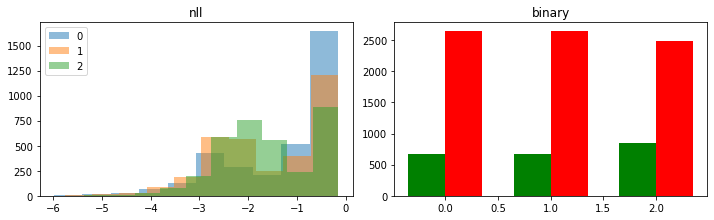

<function len_sentences at 0x127193268>


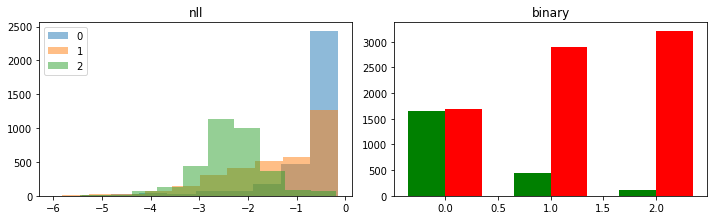

-----------------------------------------------
-----------------------------------------------
comparison__sort_src_test.txt
Number lengths:  2.443104624819625
Number of numbers:  5.3026
Words/number ratio:  1.916740785048285
Avg. sentence length:  42.4938


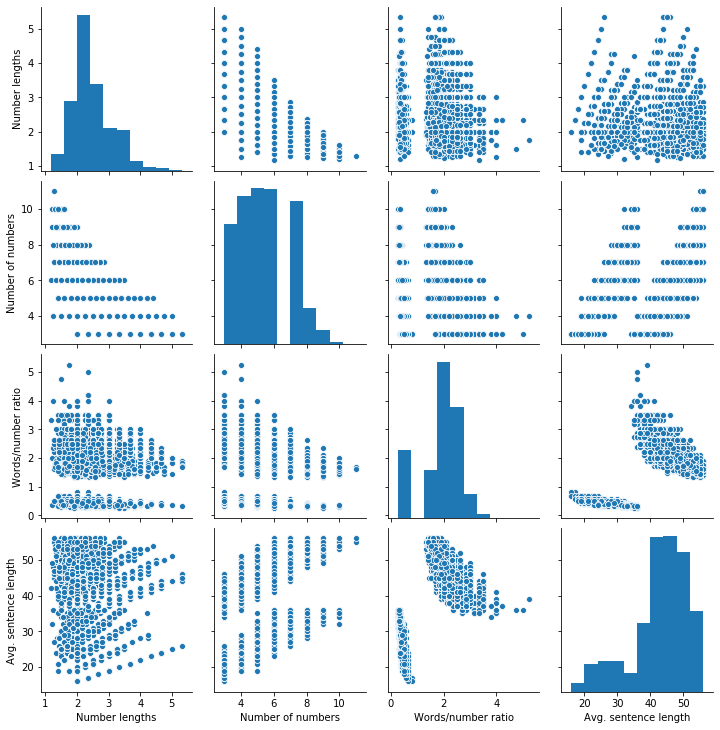

<function count_numbers_length at 0x12a74b840>


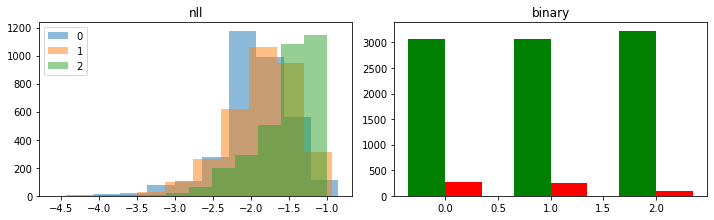

<function count_number_of_numbers at 0x127193ae8>


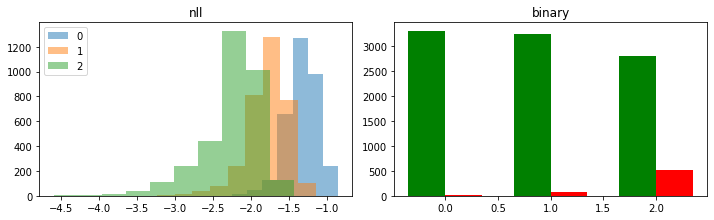

<function ratio_words_numbers at 0x127193ea0>


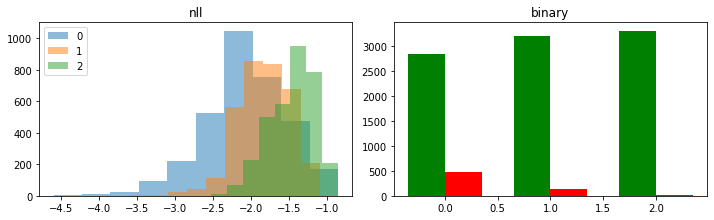

<function len_sentences at 0x127193268>


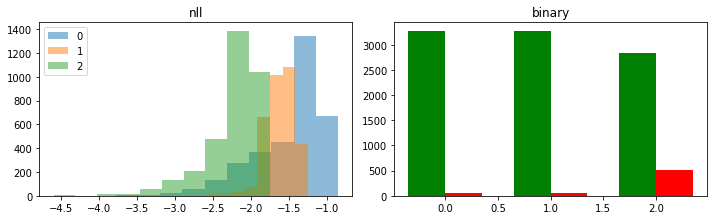

-----------------------------------------------
-----------------------------------------------
measurement__conversion_src_test.txt
Number lengths:  4.4096
Number of numbers:  1.0336
Words/number ratio:  5.07116996031746
Avg. sentence length:  43.9382


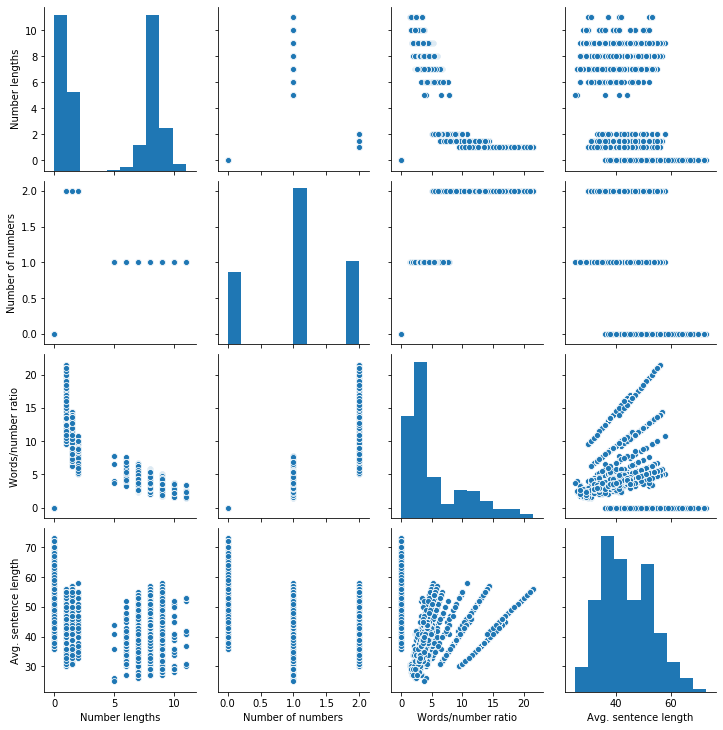

<function count_numbers_length at 0x12a74b840>


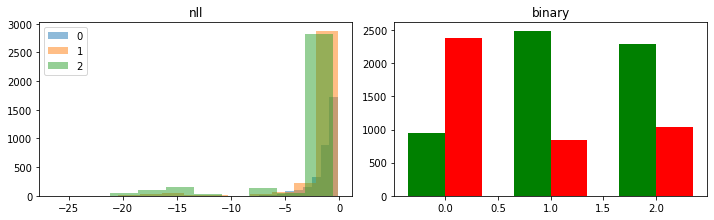

<function count_number_of_numbers at 0x127193ae8>


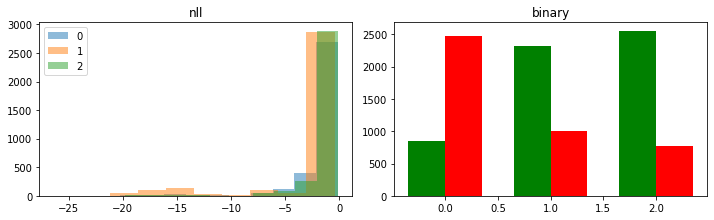

<function ratio_words_numbers at 0x127193ea0>


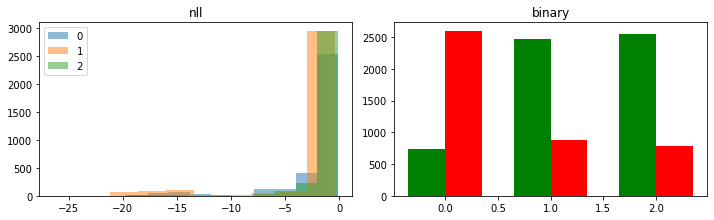

<function len_sentences at 0x127193268>


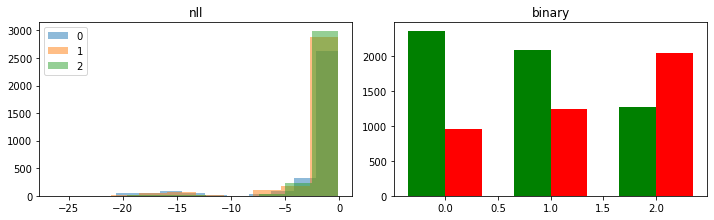

-----------------------------------------------
-----------------------------------------------
numbers__place_value_src_test.txt
Number lengths:  7.8851
Number of numbers:  1.0
Words/number ratio:  3.1865203571428573
Avg. sentence length:  40.3219


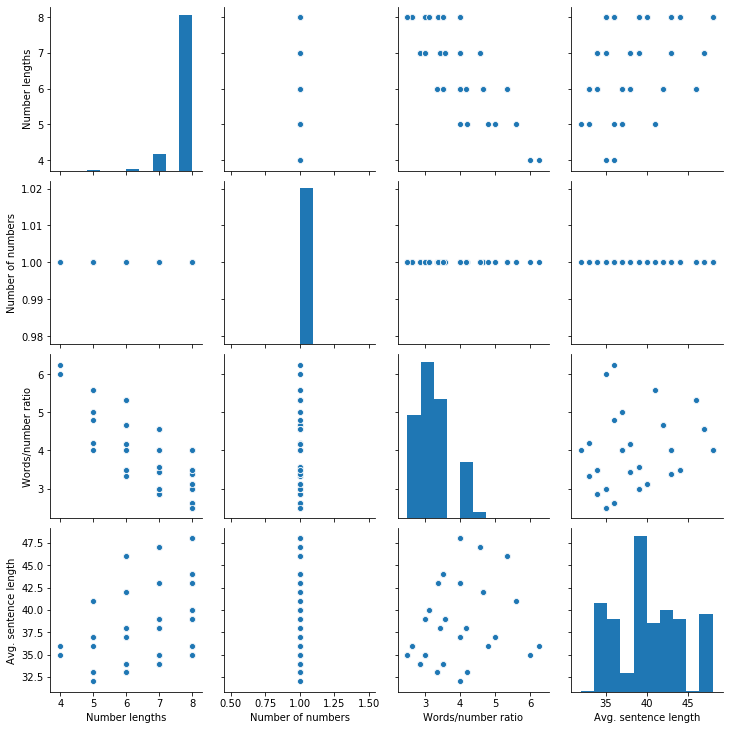

<function count_numbers_length at 0x12a74b840>


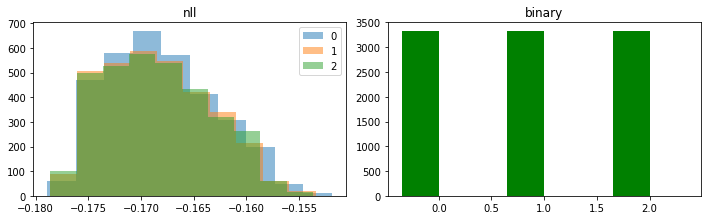

<function count_number_of_numbers at 0x127193ae8>


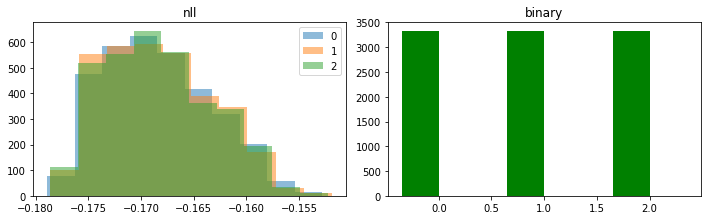

<function ratio_words_numbers at 0x127193ea0>


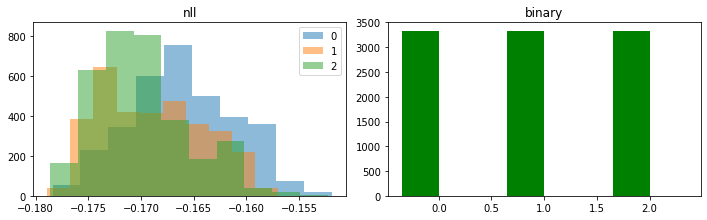

<function len_sentences at 0x127193268>


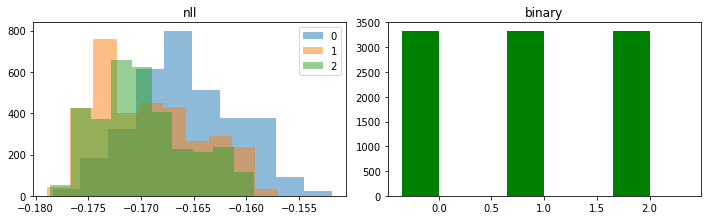

-----------------------------------------------
-----------------------------------------------
numbers__round_number_src_test.txt
Number lengths:  8.77835
Number of numbers:  1.4875
Words/number ratio:  2.3581580199947108
Avg. sentence length:  42.3404


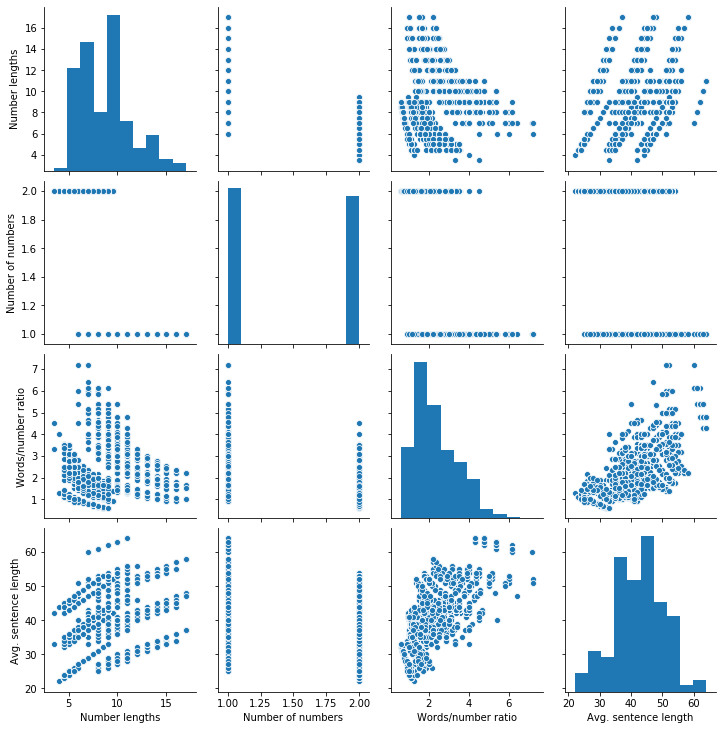

<function count_numbers_length at 0x12a74b840>


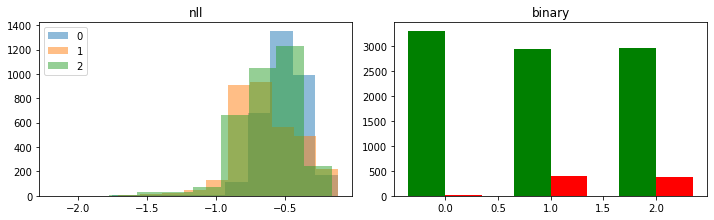

<function count_number_of_numbers at 0x127193ae8>


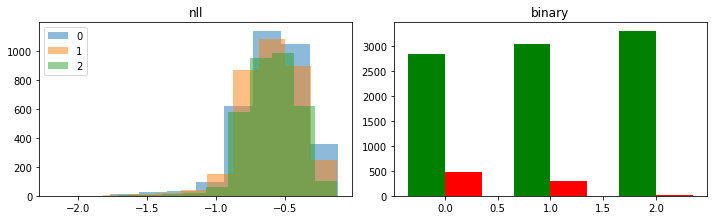

<function ratio_words_numbers at 0x127193ea0>


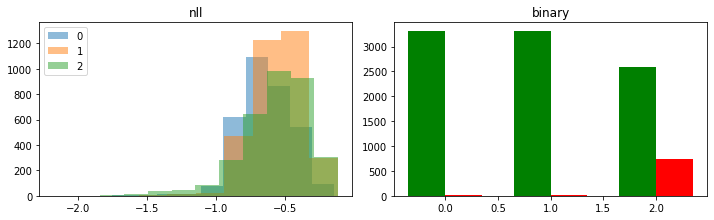

<function len_sentences at 0x127193268>


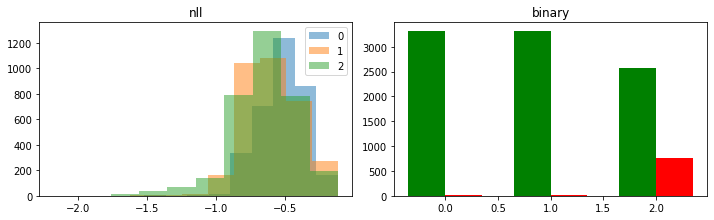

-----------------------------------------------
-----------------------------------------------
probability__swr_p_level_set_src_test.txt
Number lengths:  1.022196984126984
Number of numbers:  4.0008
Words/number ratio:  28.581449592352094
Avg. sentence length:  103.0824


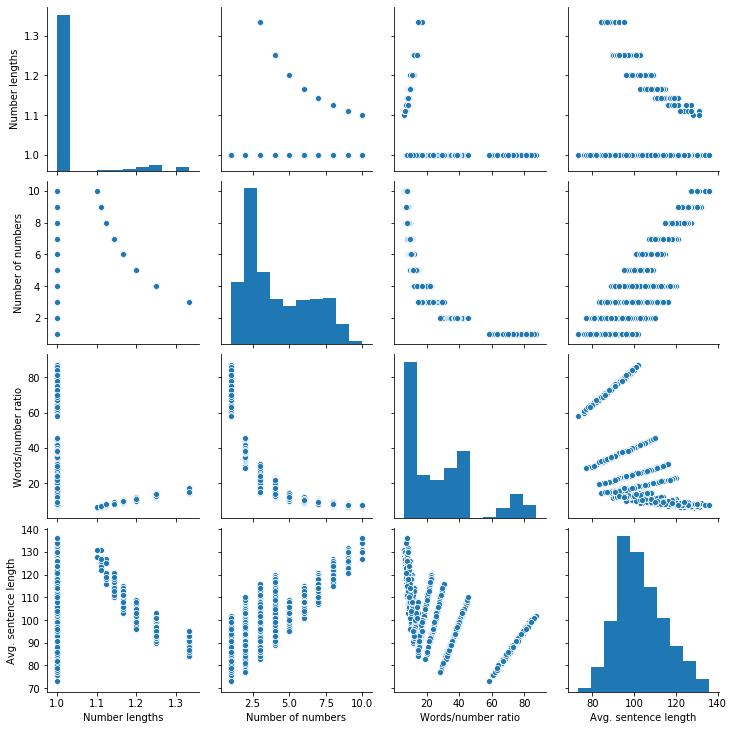

<function count_numbers_length at 0x12a74b840>


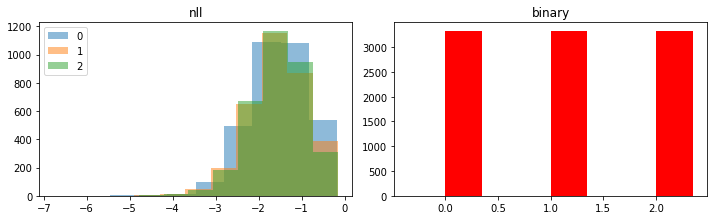

<function count_number_of_numbers at 0x127193ae8>


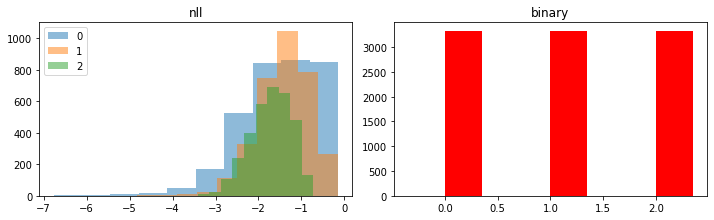

<function ratio_words_numbers at 0x127193ea0>


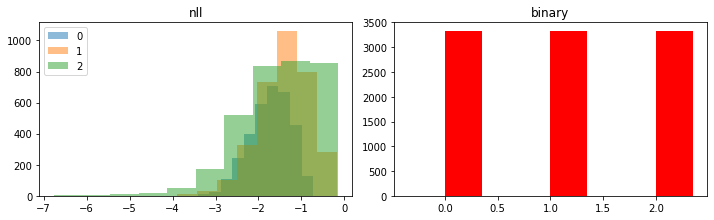

<function len_sentences at 0x127193268>


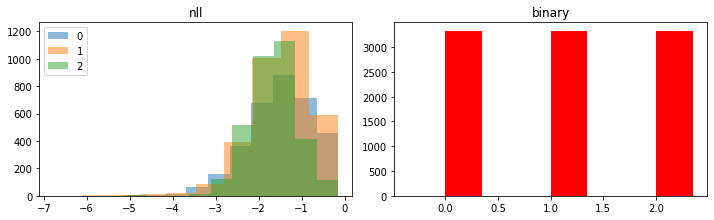

-----------------------------------------------
-----------------------------------------------
probability__swr_p_sequence_src_test.txt
Number lengths:  0.53738
Number of numbers:  2.0706
Words/number ratio:  8.980572857142857
Avg. sentence length:  96.6655


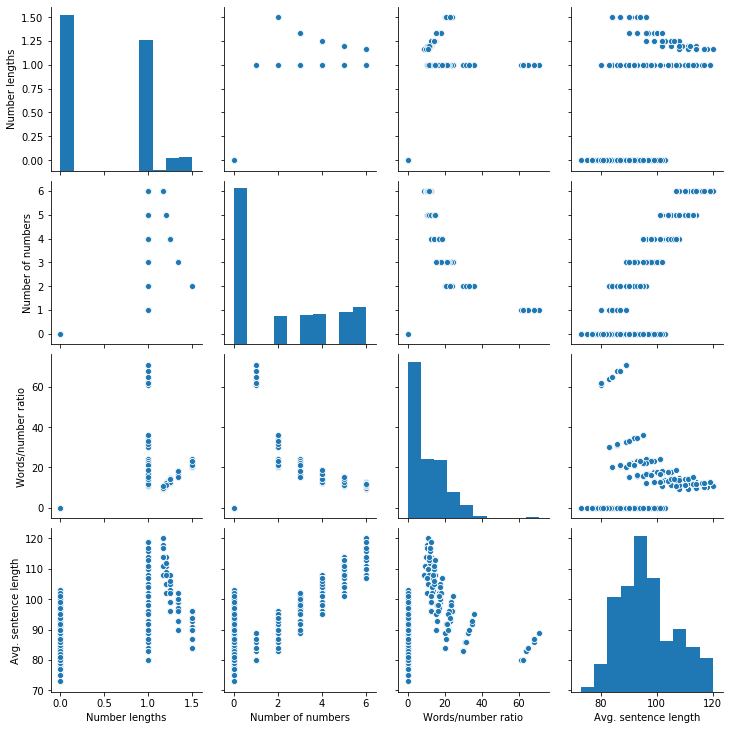

<function count_numbers_length at 0x12a74b840>


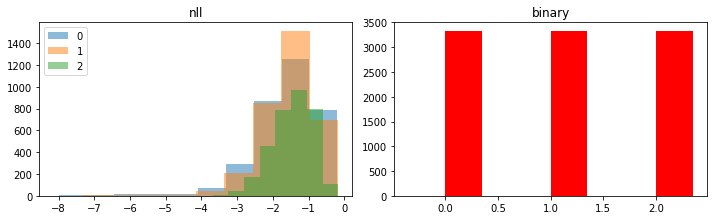

<function count_number_of_numbers at 0x127193ae8>


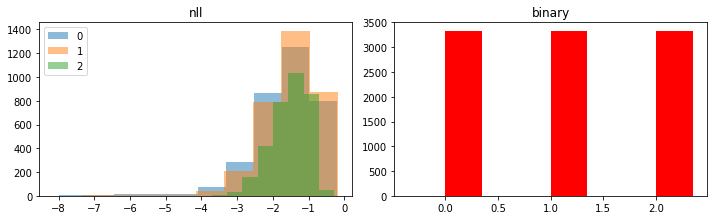

<function ratio_words_numbers at 0x127193ea0>


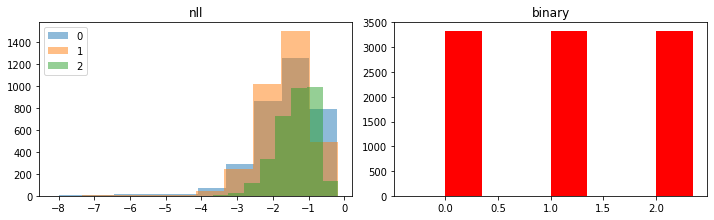

<function len_sentences at 0x127193268>


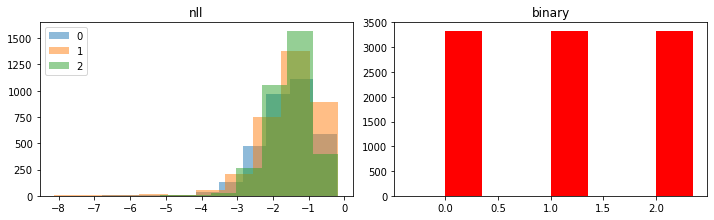

-----------------------------------------------


In [27]:
stats_func =  [compute_nll, compute_binary_accuracy]#, compute_bleu_sentence_accuracy]
stats_titles =  ['nll', 'binary']#, 'bleu_sentence']

for targetid in targetids:
    print()
    print('***********************')
    print(targetid)
    print('***********************')
    print()
    for key in sorted(data[targetid].keys()):
        print('-----------------------------------------------')
        print(key)
        results = data[targetid][key]

        task_lengths = {}
        if lengths_stats:
            for d in ['easy','medium','hard']:
                task_lengths[d] = lengths_stats[d][train_names[targetid][key]].mean()
                                
        number_lengths = count_numbers_length(results)
        print('Number lengths: ', number_lengths.mean())

        number_of_numbers = count_number_of_numbers(results)
        print('Number of numbers: ', number_of_numbers.mean())

        words_numbers_ratio = ratio_words_numbers(results)
        print('Words/number ratio: ', words_numbers_ratio.mean())

        length_sentences = len_sentences(results)
        print('Avg. sentence length: ', length_sentences.mean())

        dataset = pd.DataFrame({'Number lengths': number_lengths, 
                                'Number of numbers': number_of_numbers,
                                'Words/number ratio': words_numbers_ratio,
                                'Avg. sentence length': length_sentences})
        
        sns.pairplot(dataset)
        plt.show()

        #binary_acc = compute_binary_accuracy(results)
        #print('Binary: ', binary_acc.mean())

        #print()
        compute_statistics(results, count_numbers_length, method='equal_split', 
                           stats_func=stats_func, stats_titles=stats_titles)
        compute_statistics(results, count_number_of_numbers, method='equal_split', 
                           stats_func=stats_func, stats_titles=stats_titles)
        compute_statistics(results, ratio_words_numbers, method='equal_split', 
                           stats_func=stats_func, stats_titles=stats_titles)
        compute_statistics(results, len_sentences, method='equal_split', 
                           stats_func=stats_func, stats_titles=stats_titles, extra=task_lengths)


        #sentence_acc = compute_bleu_sentence_accuracy(results)
        #print('Sentence: ', sentence_acc.mean())

        #corpus_acc = compute_bleu_sentence_accuracy(results)
        #print('Corpus: ', sentence_acc.mean())

        print('-----------------------------------------------')